# Classification on Botnet DGA Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [2]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [3]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_5_yorktown')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-05-34/"
#"RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
#os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-05-34/


## Example of a QNode

In [4]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [5]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [6]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [7]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [8]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [9]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [10]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [11]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [12]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [13]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [16]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [17]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmpficmt69a/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [18]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 752s 58s/step - loss: 0.7111 - tp: 63.3571 - fp: 50.8571 - tn: 139.6429 - fn: 116.0000 - accuracy: 0.5396 - precision: 0.5276 - recall: 0.3355 - auc: 0.4898 - val_loss: 0.7556 - val_tp: 15.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 71.0000 - val_accuracy: 0.4403 - val_precision: 0.4545 - val_recall: 0.1744 - val_auc: 0.2584
Epoch 2/10000
13/13 [==============================] - 750s 58s/step - loss: 0.7178 - tp: 55.2143 - fp: 41.0000 - tn: 150.9286 - fn: 122.7143 - accuracy: 0.5627 - precision: 0.5680 - recall: 0.3162 - auc: 0.4855 - val_loss: 0.7457 - val_tp: 16.0000 - val_fp: 10.0000 - val_tn: 63.0000 - val_fn: 70.0000 - val_accuracy: 0.4969 - val_precision: 0.6154 - val_recall: 0.1860 - val_auc: 0.2870
Epoch 3/10000
13/13 [==============================] - 751s 58s/step - loss: 0.7236 - tp: 43.9286 - fp: 26.0000 - tn: 167.7857 - fn: 132.1429 - accuracy: 0.5719 - precision: 0.5949 - recall: 0.2389 - auc: 0.4435 - val_loss

13/13 [==============================] - 757s 58s/step - loss: 0.6199 - tp: 62.7143 - fp: 6.7143 - tn: 185.0714 - fn: 115.3571 - accuracy: 0.6598 - precision: 0.9084 - recall: 0.3223 - auc: 0.7419 - val_loss: 0.6154 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.8432
Epoch 44/10000
13/13 [==============================] - 757s 58s/step - loss: 0.5939 - tp: 74.0000 - fp: 10.0714 - tn: 183.2143 - fn: 102.5714 - accuracy: 0.7042 - precision: 0.8667 - recall: 0.4358 - auc: 0.7381 - val_loss: 0.6145 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.8442
Epoch 45/10000
13/13 [==============================] - 758s 58s/step - loss: 0.6184 - tp: 75.0714 - fp: 12.0000 - tn: 179.2857 - fn: 103.5000 - accuracy: 0.6806 - precision: 0.8541 - recall: 0.4121 - auc: 0.7012 - val_loss: 0.6134 - val_

13/13 [==============================] - 758s 58s/step - loss: 0.5722 - tp: 83.6429 - fp: 8.7857 - tn: 184.8571 - fn: 92.5714 - accuracy: 0.7278 - precision: 0.9095 - recall: 0.4681 - auc: 0.7579 - val_loss: 0.5681 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.8635
Epoch 86/10000
13/13 [==============================] - 758s 58s/step - loss: 0.5639 - tp: 89.2143 - fp: 10.0000 - tn: 175.9286 - fn: 94.7143 - accuracy: 0.7114 - precision: 0.8955 - recall: 0.4833 - auc: 0.7511 - val_loss: 0.5678 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.8761
Epoch 87/10000
13/13 [==============================] - 759s 58s/step - loss: 0.5816 - tp: 80.0000 - fp: 11.2143 - tn: 178.4286 - fn: 100.2143 - accuracy: 0.7019 - precision: 0.8702 - recall: 0.4608 - auc: 0.7325 - val_loss: 0.5668 - val_tp

13/13 [==============================] - 760s 59s/step - loss: 0.5593 - tp: 93.1429 - fp: 11.3571 - tn: 175.3571 - fn: 90.0000 - accuracy: 0.7325 - precision: 0.9004 - recall: 0.5284 - auc: 0.7446 - val_loss: 0.5453 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8675
Epoch 128/10000
13/13 [==============================] - 760s 58s/step - loss: 0.5622 - tp: 91.1429 - fp: 10.4286 - tn: 179.8571 - fn: 88.4286 - accuracy: 0.7275 - precision: 0.8957 - recall: 0.5058 - auc: 0.7501 - val_loss: 0.5464 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8561
Epoch 129/10000
13/13 [==============================] - 760s 58s/step - loss: 0.5646 - tp: 90.7857 - fp: 9.0714 - tn: 175.4286 - fn: 94.5714 - accuracy: 0.7182 - precision: 0.9220 - recall: 0.4942 - auc: 0.7263 - val_loss: 0.5418 - val_t

13/13 [==============================] - 760s 59s/step - loss: 0.5462 - tp: 92.5000 - fp: 9.0714 - tn: 181.9286 - fn: 86.3571 - accuracy: 0.7366 - precision: 0.9262 - recall: 0.5041 - auc: 0.7576 - val_loss: 0.5294 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8789
Epoch 170/10000
13/13 [==============================] - 760s 59s/step - loss: 0.5363 - tp: 97.7143 - fp: 12.0714 - tn: 182.2857 - fn: 77.7857 - accuracy: 0.7558 - precision: 0.8721 - recall: 0.5603 - auc: 0.7709 - val_loss: 0.5275 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8812
Epoch 171/10000
13/13 [==============================] - 762s 59s/step - loss: 0.5111 - tp: 95.5714 - fp: 7.9286 - tn: 186.5714 - fn: 79.7857 - accuracy: 0.7736 - precision: 0.9249 - recall: 0.5666 - auc: 0.7924 - val_loss: 0.5260 - val_tp

13/13 [==============================] - 723s 56s/step - loss: 0.5098 - tp: 100.7143 - fp: 4.1429 - tn: 187.0000 - fn: 78.0000 - accuracy: 0.7688 - precision: 0.9630 - recall: 0.5419 - auc: 0.7908 - val_loss: 0.5141 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9076
Epoch 212/10000
13/13 [==============================] - 724s 56s/step - loss: 0.5348 - tp: 94.0000 - fp: 12.6429 - tn: 180.7857 - fn: 82.4286 - accuracy: 0.7494 - precision: 0.8926 - recall: 0.5430 - auc: 0.7570 - val_loss: 0.5140 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9160
Epoch 213/10000
13/13 [==============================] - 720s 55s/step - loss: 0.5249 - tp: 105.5714 - fp: 10.9286 - tn: 180.3571 - fn: 73.0000 - accuracy: 0.7683 - precision: 0.8997 - recall: 0.5791 - auc: 0.7528 - val_loss: 0.5154 - val

13/13 [==============================] - 723s 56s/step - loss: 0.4977 - tp: 101.7857 - fp: 7.1429 - tn: 186.6429 - fn: 74.2857 - accuracy: 0.7791 - precision: 0.9259 - recall: 0.5754 - auc: 0.7919 - val_loss: 0.5068 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9256
Epoch 254/10000
13/13 [==============================] - 721s 55s/step - loss: 0.4768 - tp: 112.6429 - fp: 7.2143 - tn: 182.7143 - fn: 67.2857 - accuracy: 0.8024 - precision: 0.9373 - recall: 0.6291 - auc: 0.8081 - val_loss: 0.5051 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9282
Epoch 255/10000
13/13 [==============================] - 723s 56s/step - loss: 0.4756 - tp: 110.2857 - fp: 6.4286 - tn: 183.1429 - fn: 70.0000 - accuracy: 0.7978 - precision: 0.9533 - recall: 0.6135 - auc: 0.8130 - val_loss: 0.5051 - val_

13/13 [==============================] - 723s 56s/step - loss: 0.4852 - tp: 109.2143 - fp: 10.0000 - tn: 179.1429 - fn: 71.5000 - accuracy: 0.7808 - precision: 0.9081 - recall: 0.6105 - auc: 0.8039 - val_loss: 0.4956 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9384
Epoch 296/10000
13/13 [==============================] - 721s 55s/step - loss: 0.4892 - tp: 112.4286 - fp: 10.2143 - tn: 181.0714 - fn: 66.1429 - accuracy: 0.7900 - precision: 0.9108 - recall: 0.6294 - auc: 0.8106 - val_loss: 0.4987 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9381
Epoch 297/10000
13/13 [==============================] - 721s 56s/step - loss: 0.4775 - tp: 106.7143 - fp: 6.8571 - tn: 185.7143 - fn: 70.5714 - accuracy: 0.7922 - precision: 0.9449 - recall: 0.6044 - auc: 0.8073 - val_loss: 0.4963 - va

13/13 [==============================] - 722s 56s/step - loss: 0.5095 - tp: 95.8571 - fp: 7.6429 - tn: 192.2857 - fn: 74.0714 - accuracy: 0.7737 - precision: 0.9152 - recall: 0.5500 - auc: 0.7493 - val_loss: 0.4898 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9470
Epoch 338/10000
13/13 [==============================] - 722s 56s/step - loss: 0.5029 - tp: 97.0714 - fp: 8.2857 - tn: 188.1429 - fn: 76.3571 - accuracy: 0.7761 - precision: 0.9272 - recall: 0.5568 - auc: 0.7683 - val_loss: 0.4936 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9365
Epoch 339/10000
13/13 [==============================] - 722s 56s/step - loss: 0.4893 - tp: 113.1429 - fp: 7.1429 - tn: 181.5000 - fn: 68.0714 - accuracy: 0.7866 - precision: 0.9478 - recall: 0.6114 - auc: 0.7986 - val_loss: 0.4912 - val_tp

13/13 [==============================] - 722s 56s/step - loss: 0.4778 - tp: 108.8571 - fp: 4.9286 - tn: 187.2143 - fn: 68.8571 - accuracy: 0.8009 - precision: 0.9597 - recall: 0.6161 - auc: 0.7928 - val_loss: 0.4865 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9426
Epoch 380/10000
13/13 [==============================] - 723s 56s/step - loss: 0.5041 - tp: 98.8571 - fp: 7.7857 - tn: 186.7857 - fn: 76.4286 - accuracy: 0.7707 - precision: 0.9186 - recall: 0.5621 - auc: 0.7606 - val_loss: 0.4872 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9450
Epoch 381/10000
13/13 [==============================] - 726s 56s/step - loss: 0.4558 - tp: 110.6429 - fp: 5.8571 - tn: 188.2857 - fn: 65.0714 - accuracy: 0.8097 - precision: 0.9491 - recall: 0.6366 - auc: 0.7994 - val_loss: 0.4848 - val_t

13/13 [==============================] - 722s 56s/step - loss: 0.4651 - tp: 107.6429 - fp: 5.0000 - tn: 189.8571 - fn: 67.3571 - accuracy: 0.8104 - precision: 0.9587 - recall: 0.6193 - auc: 0.8019 - val_loss: 0.4799 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9474
Epoch 422/10000
13/13 [==============================] - 725s 56s/step - loss: 0.4841 - tp: 110.2143 - fp: 8.5714 - tn: 183.4286 - fn: 67.6429 - accuracy: 0.7864 - precision: 0.9064 - recall: 0.6098 - auc: 0.7869 - val_loss: 0.4790 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9461
Epoch 423/10000
13/13 [==============================] - 722s 56s/step - loss: 0.5293 - tp: 101.2143 - fp: 8.0000 - tn: 175.6429 - fn: 85.0000 - accuracy: 0.7338 - precision: 0.9196 - recall: 0.5353 - auc: 0.7584 - val_loss: 0.4791 - val_

13/13 [==============================] - 723s 56s/step - loss: 0.4805 - tp: 99.0714 - fp: 4.0000 - tn: 188.2857 - fn: 78.5000 - accuracy: 0.7825 - precision: 0.9663 - recall: 0.5674 - auc: 0.7914 - val_loss: 0.4695 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9521
Epoch 464/10000
13/13 [==============================] - 724s 56s/step - loss: 0.4798 - tp: 106.6429 - fp: 8.3571 - tn: 180.2143 - fn: 74.6429 - accuracy: 0.7778 - precision: 0.9275 - recall: 0.5937 - auc: 0.8044 - val_loss: 0.4709 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9440
Epoch 465/10000
13/13 [==============================] - 723s 56s/step - loss: 0.4401 - tp: 115.5000 - fp: 6.5000 - tn: 187.0714 - fn: 60.7857 - accuracy: 0.8232 - precision: 0.9475 - recall: 0.6594 - auc: 0.8170 - val_loss: 0.4697 - val_t

13/13 [==============================] - 723s 56s/step - loss: 0.4913 - tp: 110.7143 - fp: 5.3571 - tn: 178.2857 - fn: 75.5000 - accuracy: 0.7684 - precision: 0.9505 - recall: 0.5875 - auc: 0.8109 - val_loss: 0.4724 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9482
Epoch 506/10000
13/13 [==============================] - 724s 56s/step - loss: 0.4684 - tp: 111.7143 - fp: 4.8571 - tn: 185.4286 - fn: 67.8571 - accuracy: 0.8014 - precision: 0.9556 - recall: 0.6076 - auc: 0.7819 - val_loss: 0.4678 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9380
Epoch 507/10000
13/13 [==============================] - 724s 56s/step - loss: 0.4723 - tp: 109.5714 - fp: 7.8571 - tn: 185.6429 - fn: 66.7857 - accuracy: 0.7947 - precision: 0.9281 - recall: 0.6072 - auc: 0.7822 - val_loss: 0.4731 - val_

13/13 [==============================] - 723s 56s/step - loss: 0.4596 - tp: 119.0714 - fp: 9.0000 - tn: 181.5000 - fn: 60.2857 - accuracy: 0.8098 - precision: 0.9294 - recall: 0.6636 - auc: 0.8189 - val_loss: 0.4610 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9527
Epoch 548/10000
13/13 [==============================] - 724s 56s/step - loss: 0.4457 - tp: 112.2143 - fp: 7.4286 - tn: 186.8571 - fn: 63.3571 - accuracy: 0.8191 - precision: 0.9416 - recall: 0.6572 - auc: 0.8086 - val_loss: 0.4662 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9563
Epoch 549/10000
13/13 [==============================] - 724s 56s/step - loss: 0.4907 - tp: 108.0000 - fp: 7.1429 - tn: 180.6429 - fn: 74.0714 - accuracy: 0.7710 - precision: 0.9354 - recall: 0.5700 - auc: 0.7456 - val_loss: 0.4610 - val_

13/13 [==============================] - 724s 56s/step - loss: 0.4578 - tp: 111.3571 - fp: 5.2143 - tn: 189.5714 - fn: 63.7143 - accuracy: 0.8136 - precision: 0.9619 - recall: 0.6180 - auc: 0.7979 - val_loss: 0.4553 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9432
Epoch 590/10000
13/13 [==============================] - 725s 56s/step - loss: 0.4816 - tp: 110.8571 - fp: 8.1429 - tn: 178.2857 - fn: 72.5714 - accuracy: 0.7900 - precision: 0.9387 - recall: 0.6185 - auc: 0.7839 - val_loss: 0.4565 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9532
Epoch 591/10000
13/13 [==============================] - 725s 56s/step - loss: 0.4385 - tp: 111.6429 - fp: 4.5000 - tn: 190.0714 - fn: 63.6429 - accuracy: 0.8238 - precision: 0.9711 - recall: 0.6469 - auc: 0.8322 - val_loss: 0.4590 - val_

13/13 [==============================] - 723s 56s/step - loss: 0.4977 - tp: 104.0000 - fp: 8.0000 - tn: 184.2857 - fn: 73.5714 - accuracy: 0.7770 - precision: 0.9240 - recall: 0.5778 - auc: 0.7451 - val_loss: 0.4573 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9493
Epoch 632/10000
13/13 [==============================] - 725s 56s/step - loss: 0.4687 - tp: 106.3571 - fp: 4.4286 - tn: 189.2857 - fn: 69.7857 - accuracy: 0.8047 - precision: 0.9626 - recall: 0.6085 - auc: 0.7667 - val_loss: 0.4503 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9541
Epoch 633/10000
13/13 [==============================] - 724s 56s/step - loss: 0.4343 - tp: 121.2857 - fp: 6.1429 - tn: 184.0000 - fn: 58.4286 - accuracy: 0.8274 - precision: 0.9573 - recall: 0.6837 - auc: 0.8184 - val_loss: 0.4564 - val_

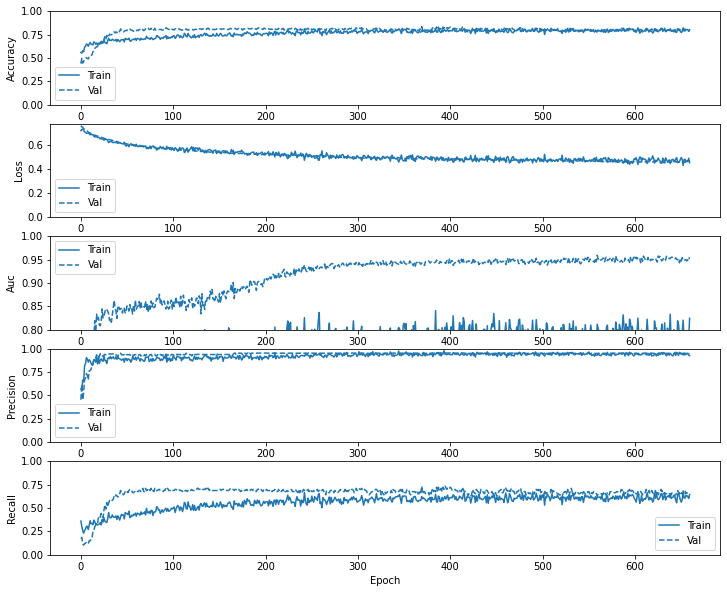

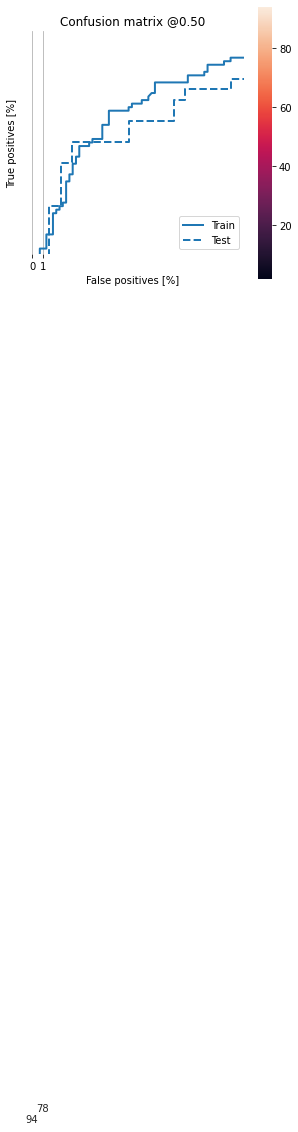

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 690s 53s/step - loss: 0.9166 - tp: 243.9286 - fp: 192.5000 - tn: 94.0000 - fn: 38.4286 - accuracy: 0.6153 - precision: 0.5853 - recall: 0.8537 - auc: 0.6786 - val_loss: 0.8078 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6624
Epoch 2/10000
13/13 [==============================] - 693s 53s/step - loss: 0.9101 - tp: 163.9286 - fp: 191.9286 - tn: 0.0000e+00 - fn: 14.0000 - accuracy: 0.4342 - precision: 0.4516 - recall: 0.9176 - auc: 0.4849 - val_loss: 0.7945 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6917
Epoch 3/10000
13/13 [==============================] - 693s 53s/step - loss: 0.9155 - tp: 157.6429 - fp: 193.4286 - tn: 0.3571 - fn: 18.4286 - accuracy: 0.4172 - precision: 0.4379 - recall: 0.8981 - auc: 0.4

Epoch 22/10000
13/13 [==============================] - 692s 53s/step - loss: 0.6708 - tp: 171.5000 - fp: 185.8571 - tn: 1.7143 - fn: 10.7857 - accuracy: 0.4704 - precision: 0.4848 - recall: 0.9342 - auc: 0.6262 - val_loss: 0.6205 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8226
Epoch 23/10000
13/13 [==============================] - 693s 53s/step - loss: 0.6609 - tp: 173.7857 - fp: 187.6429 - tn: 0.7857 - fn: 7.6429 - accuracy: 0.4768 - precision: 0.4859 - recall: 0.9595 - auc: 0.6589 - val_loss: 0.6187 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8034
Epoch 24/10000
13/13 [==============================] - 692s 53s/step - loss: 0.6683 - tp: 165.2857 - fp: 193.4286 - tn: 0.2857 - fn: 10.8571 - accuracy: 0.4507 - precision: 0.4655 - recall: 0.9336 - auc: 0.6324

Epoch 43/10000
13/13 [==============================] - 693s 53s/step - loss: 0.6024 - tp: 63.1429 - fp: 3.2143 - tn: 188.5714 - fn: 114.9286 - accuracy: 0.6855 - precision: 0.9464 - recall: 0.3649 - auc: 0.6634 - val_loss: 0.5618 - val_tp: 63.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 23.0000 - val_accuracy: 0.7987 - val_precision: 0.8750 - val_recall: 0.7326 - val_auc: 0.8137
Epoch 44/10000
13/13 [==============================] - 694s 53s/step - loss: 0.5905 - tp: 74.7857 - fp: 9.0714 - tn: 184.2143 - fn: 101.7857 - accuracy: 0.7168 - precision: 0.8835 - recall: 0.4587 - auc: 0.6877 - val_loss: 0.5630 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8234
Epoch 45/10000
13/13 [==============================] - 693s 53s/step - loss: 0.6079 - tp: 68.3571 - fp: 9.2143 - tn: 182.0714 - fn: 110.2143 - accuracy: 0.6712 - precision: 0.8693 - recall: 0.3796 - auc: 0.6798 - val_loss: 

13/13 [==============================] - 670s 51s/step - loss: 0.5419 - tp: 77.5000 - fp: 6.8571 - tn: 186.7857 - fn: 98.7143 - accuracy: 0.7203 - precision: 0.9221 - recall: 0.4440 - auc: 0.7877 - val_loss: 0.5224 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8829
Epoch 86/10000
13/13 [==============================] - 658s 51s/step - loss: 0.5474 - tp: 83.9286 - fp: 7.5714 - tn: 178.3571 - fn: 100.0000 - accuracy: 0.7086 - precision: 0.9262 - recall: 0.4579 - auc: 0.7804 - val_loss: 0.5223 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8786
Epoch 87/10000
13/13 [==============================] - 660s 51s/step - loss: 0.5636 - tp: 67.8571 - fp: 5.0714 - tn: 184.5714 - fn: 112.3571 - accuracy: 0.6858 - precision: 0.9276 - recall: 0.3875 - auc: 0.7612 - val_loss: 0.5199 - val_tp:

13/13 [==============================] - 662s 51s/step - loss: 0.4947 - tp: 85.5000 - fp: 15.7857 - tn: 170.9286 - fn: 97.6429 - accuracy: 0.6922 - precision: 0.8489 - recall: 0.4772 - auc: 0.8090 - val_loss: 0.4518 - val_tp: 74.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 12.0000 - val_accuracy: 0.8679 - val_precision: 0.8916 - val_recall: 0.8605 - val_auc: 0.9224
Epoch 128/10000
13/13 [==============================] - 665s 51s/step - loss: 0.5026 - tp: 83.2857 - fp: 13.9286 - tn: 176.3571 - fn: 96.2857 - accuracy: 0.6880 - precision: 0.8438 - recall: 0.4502 - auc: 0.8111 - val_loss: 0.4500 - val_tp: 75.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 11.0000 - val_accuracy: 0.8742 - val_precision: 0.8929 - val_recall: 0.8721 - val_auc: 0.9229
Epoch 129/10000
13/13 [==============================] - 659s 51s/step - loss: 0.5180 - tp: 84.1429 - fp: 14.6429 - tn: 169.8571 - fn: 101.2143 - accuracy: 0.6866 - precision: 0.8791 - recall: 0.4555 - auc: 0.7960 - val_loss: 0.4481 - val

13/13 [==============================] - 660s 51s/step - loss: 0.4763 - tp: 90.0000 - fp: 22.2143 - tn: 168.7857 - fn: 88.8571 - accuracy: 0.6960 - precision: 0.8116 - recall: 0.4950 - auc: 0.8226 - val_loss: 0.4270 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9407
Epoch 170/10000
13/13 [==============================] - 661s 51s/step - loss: 0.5026 - tp: 83.0714 - fp: 20.1429 - tn: 174.2143 - fn: 92.4286 - accuracy: 0.6966 - precision: 0.7969 - recall: 0.4701 - auc: 0.7996 - val_loss: 0.4246 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9411
Epoch 171/10000
13/13 [==============================] - 658s 51s/step - loss: 0.4904 - tp: 78.9286 - fp: 15.0000 - tn: 179.5000 - fn: 96.4286 - accuracy: 0.7094 - precision: 0.8391 - recall: 0.4758 - auc: 0.8024 - val_loss: 0.4250 - val_

13/13 [==============================] - 660s 51s/step - loss: 0.4661 - tp: 102.2143 - fp: 32.0000 - tn: 159.1429 - fn: 76.5000 - accuracy: 0.7088 - precision: 0.7728 - recall: 0.5636 - auc: 0.8259 - val_loss: 0.4087 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9452
Epoch 212/10000
13/13 [==============================] - 659s 51s/step - loss: 0.4778 - tp: 100.4286 - fp: 39.7143 - tn: 153.7143 - fn: 76.0000 - accuracy: 0.6934 - precision: 0.7207 - recall: 0.5860 - auc: 0.8214 - val_loss: 0.4111 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9419
Epoch 213/10000
13/13 [==============================] - 658s 51s/step - loss: 0.4905 - tp: 91.4286 - fp: 33.0000 - tn: 158.2857 - fn: 87.1429 - accuracy: 0.6662 - precision: 0.7166 - recall: 0.4970 - auc: 0.7815 - val_loss: 0.4135 - va

13/13 [==============================] - 659s 51s/step - loss: 0.4781 - tp: 85.2143 - fp: 20.7857 - tn: 173.0000 - fn: 90.8571 - accuracy: 0.6987 - precision: 0.7949 - recall: 0.4828 - auc: 0.8115 - val_loss: 0.4007 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9457
Epoch 254/10000
13/13 [==============================] - 660s 51s/step - loss: 0.4384 - tp: 96.1429 - fp: 24.0000 - tn: 165.9286 - fn: 83.7857 - accuracy: 0.7050 - precision: 0.7879 - recall: 0.5181 - auc: 0.8185 - val_loss: 0.3960 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9498
Epoch 255/10000
13/13 [==============================] - 660s 51s/step - loss: 0.4914 - tp: 86.0714 - fp: 24.7857 - tn: 164.7857 - fn: 94.2143 - accuracy: 0.6713 - precision: 0.7575 - recall: 0.4747 - auc: 0.7872 - val_loss: 0.3995 - val_

13/13 [==============================] - 661s 51s/step - loss: 0.4704 - tp: 94.5000 - fp: 28.1429 - tn: 161.0000 - fn: 86.2143 - accuracy: 0.6896 - precision: 0.7615 - recall: 0.5247 - auc: 0.8103 - val_loss: 0.3981 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9458
Epoch 296/10000
13/13 [==============================] - 660s 51s/step - loss: 0.4520 - tp: 104.4286 - fp: 32.4286 - tn: 158.8571 - fn: 74.1429 - accuracy: 0.7047 - precision: 0.7541 - recall: 0.5824 - auc: 0.8270 - val_loss: 0.3938 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9520
Epoch 297/10000
13/13 [==============================] - 658s 51s/step - loss: 0.4927 - tp: 91.4286 - fp: 29.7857 - tn: 162.7857 - fn: 85.8571 - accuracy: 0.6799 - precision: 0.7588 - recall: 0.4962 - auc: 0.7907 - val_loss: 0.3934 - val

13/13 [==============================] - 659s 51s/step - loss: 0.4766 - tp: 91.6429 - fp: 29.5714 - tn: 170.3571 - fn: 78.2857 - accuracy: 0.7017 - precision: 0.7322 - recall: 0.5388 - auc: 0.8051 - val_loss: 0.3910 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9454
Epoch 338/10000
13/13 [==============================] - 659s 51s/step - loss: 0.4948 - tp: 89.3571 - fp: 30.5714 - tn: 165.8571 - fn: 84.0714 - accuracy: 0.6904 - precision: 0.7363 - recall: 0.5075 - auc: 0.7967 - val_loss: 0.3877 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9498
Epoch 339/10000
13/13 [==============================] - 661s 51s/step - loss: 0.4476 - tp: 100.6429 - fp: 29.2143 - tn: 159.4286 - fn: 80.5714 - accuracy: 0.7051 - precision: 0.8010 - recall: 0.5516 - auc: 0.8304 - val_loss: 0.3878 - val

13/13 [==============================] - 660s 51s/step - loss: 0.4531 - tp: 101.5000 - fp: 32.7143 - tn: 159.4286 - fn: 76.2143 - accuracy: 0.7162 - precision: 0.7739 - recall: 0.5858 - auc: 0.8312 - val_loss: 0.3900 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9489
Epoch 380/10000
13/13 [==============================] - 660s 51s/step - loss: 0.4466 - tp: 94.7857 - fp: 29.0000 - tn: 165.5714 - fn: 80.5000 - accuracy: 0.7049 - precision: 0.7625 - recall: 0.5427 - auc: 0.8366 - val_loss: 0.3861 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9537
Epoch 381/10000
13/13 [==============================] - 659s 51s/step - loss: 0.4670 - tp: 107.5000 - fp: 39.1429 - tn: 155.0000 - fn: 68.2143 - accuracy: 0.7103 - precision: 0.7402 - recall: 0.6095 - auc: 0.8197 - val_loss: 0.3898 - val

13/13 [==============================] - 661s 51s/step - loss: 0.4320 - tp: 100.2143 - fp: 28.4286 - tn: 166.4286 - fn: 74.7857 - accuracy: 0.7289 - precision: 0.7839 - recall: 0.5753 - auc: 0.8475 - val_loss: 0.3786 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9508
Epoch 422/10000
13/13 [==============================] - 662s 51s/step - loss: 0.4679 - tp: 99.5000 - fp: 33.1429 - tn: 158.8571 - fn: 78.3571 - accuracy: 0.6822 - precision: 0.7157 - recall: 0.5467 - auc: 0.8067 - val_loss: 0.3787 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9511
Epoch 423/10000
13/13 [==============================] - 659s 51s/step - loss: 0.5040 - tp: 96.9286 - fp: 35.2143 - tn: 148.4286 - fn: 89.2857 - accuracy: 0.6542 - precision: 0.7409 - recall: 0.5137 - auc: 0.7838 - val_loss: 0.3803 - val_

13/13 [==============================] - 657s 51s/step - loss: 0.4719 - tp: 99.0714 - fp: 35.5714 - tn: 156.7143 - fn: 78.5000 - accuracy: 0.6947 - precision: 0.7375 - recall: 0.5669 - auc: 0.8198 - val_loss: 0.3858 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9511
Epoch 464/10000
13/13 [==============================] - 657s 51s/step - loss: 0.4839 - tp: 100.1429 - fp: 38.6429 - tn: 149.9286 - fn: 81.1429 - accuracy: 0.6685 - precision: 0.7120 - recall: 0.5437 - auc: 0.7842 - val_loss: 0.3849 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9501
Epoch 465/10000
13/13 [==============================] - 660s 51s/step - loss: 0.4474 - tp: 104.3571 - fp: 33.8571 - tn: 159.7143 - fn: 71.9286 - accuracy: 0.7072 - precision: 0.7344 - recall: 0.5861 - auc: 0.8131 - val_loss: 0.3887 - va

13/13 [==============================] - 658s 51s/step - loss: 0.4775 - tp: 114.1429 - fp: 32.9286 - tn: 150.7143 - fn: 72.0714 - accuracy: 0.7077 - precision: 0.7791 - recall: 0.6130 - auc: 0.8126 - val_loss: 0.3798 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9508
Epoch 506/10000
13/13 [==============================] - 658s 51s/step - loss: 0.4860 - tp: 102.5714 - fp: 30.0000 - tn: 160.2857 - fn: 77.0000 - accuracy: 0.7104 - precision: 0.7638 - recall: 0.5636 - auc: 0.8178 - val_loss: 0.3751 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9530
Epoch 507/10000
13/13 [==============================] - 658s 51s/step - loss: 0.4667 - tp: 97.6429 - fp: 24.4286 - tn: 169.0714 - fn: 78.7143 - accuracy: 0.7339 - precision: 0.8173 - recall: 0.5600 - auc: 0.8280 - val_loss: 0.3745 - val

13/13 [==============================] - 659s 51s/step - loss: 0.4411 - tp: 121.7143 - fp: 42.4286 - tn: 148.0714 - fn: 57.6429 - accuracy: 0.7419 - precision: 0.7548 - recall: 0.6989 - auc: 0.8384 - val_loss: 0.3711 - val_tp: 78.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 8.0000 - val_accuracy: 0.9182 - val_precision: 0.9398 - val_recall: 0.9070 - val_auc: 0.9514
Epoch 548/10000
13/13 [==============================] - 659s 51s/step - loss: 0.4512 - tp: 111.8571 - fp: 48.9286 - tn: 145.3571 - fn: 63.7143 - accuracy: 0.7018 - precision: 0.6954 - recall: 0.6533 - auc: 0.8186 - val_loss: 0.3687 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9539
Epoch 549/10000
13/13 [==============================] - 660s 51s/step - loss: 0.4614 - tp: 107.6429 - fp: 53.0000 - tn: 134.7857 - fn: 74.4286 - accuracy: 0.6467 - precision: 0.6584 - recall: 0.5740 - auc: 0.7948 - val_loss: 0.3704 - va

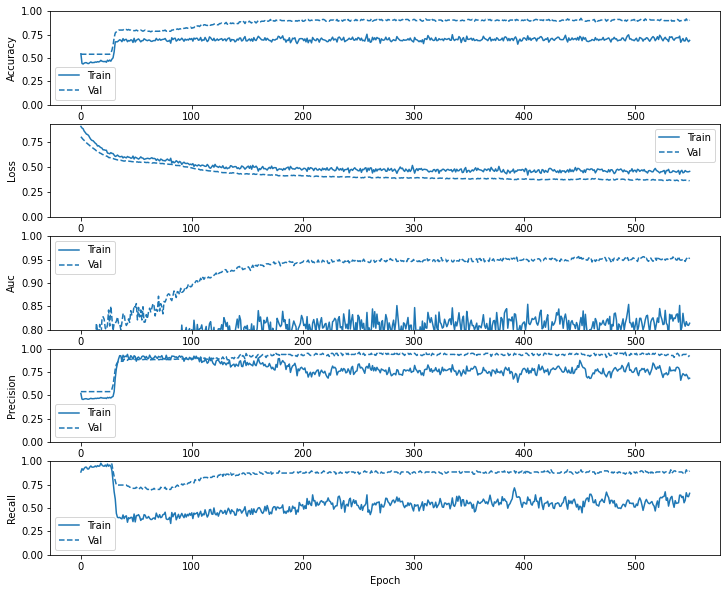

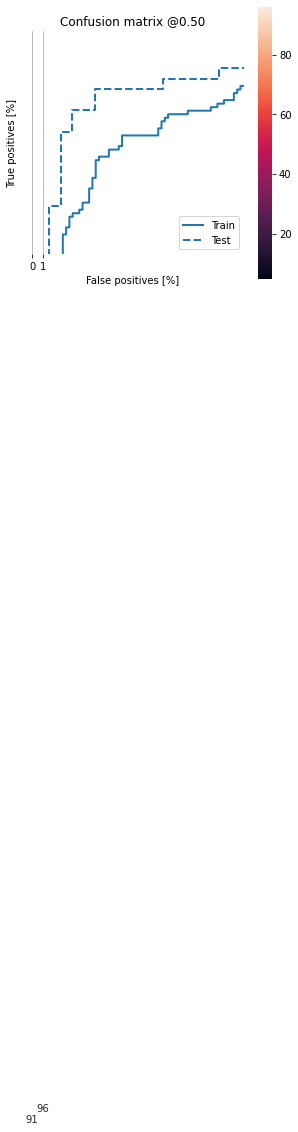

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 894s 69s/step - loss: 0.6791 - tp: 39.3571 - fp: 27.7857 - tn: 162.7143 - fn: 140.0000 - accuracy: 0.5378 - precision: 0.5563 - recall: 0.2263 - auc: 0.5275 - val_loss: 0.6727 - val_tp: 43.0000 - val_fp: 10.0000 - val_tn: 63.0000 - val_fn: 43.0000 - val_accuracy: 0.6667 - val_precision: 0.8113 - val_recall: 0.5000 - val_auc: 0.7048
Epoch 2/10000
13/13 [==============================] - 908s 70s/step - loss: 0.6737 - tp: 40.0000 - fp: 16.2857 - tn: 175.6429 - fn: 137.9286 - accuracy: 0.5906 - precision: 0.7034 - recall: 0.2333 - auc: 0.5708 - val_loss: 0.6691 - val_tp: 45.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 41.0000 - val_accuracy: 0.6855 - val_precision: 0.8333 - val_recall: 0.5233 - val_auc: 0.7111
Epoch 3/10000
13/13 [==============================] - 908s 70s/step - loss: 0.6598 - tp: 46.7143 - fp: 7.1429 - tn: 186.6429 - fn: 129.3571 - accuracy: 0.6450 - precision: 0.8866 - recall: 0.2711 - auc: 0.6240 - val_loss: 

13/13 [==============================] - 906s 70s/step - loss: 0.6106 - tp: 64.9286 - fp: 8.5000 - tn: 179.0714 - fn: 117.3571 - accuracy: 0.6569 - precision: 0.8908 - recall: 0.3576 - auc: 0.7295 - val_loss: 0.6060 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.7784
Epoch 23/10000
13/13 [==============================] - 906s 70s/step - loss: 0.6257 - tp: 53.9286 - fp: 6.3571 - tn: 182.0714 - fn: 127.5000 - accuracy: 0.6313 - precision: 0.9047 - recall: 0.2873 - auc: 0.7418 - val_loss: 0.6026 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.8390
Epoch 24/10000
13/13 [==============================] - 905s 70s/step - loss: 0.6038 - tp: 56.6429 - fp: 5.5714 - tn: 188.1429 - fn: 119.5000 - accuracy: 0.6639 - precision: 0.9226 - recall: 0.3295 - auc: 0.7578 - val_loss: 0.6027 - val_tp

13/13 [==============================] - 909s 70s/step - loss: 0.6016 - tp: 68.3571 - fp: 5.8571 - tn: 185.9286 - fn: 109.7143 - accuracy: 0.6863 - precision: 0.9273 - recall: 0.3759 - auc: 0.7183 - val_loss: 0.5783 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 40.0000 - val_accuracy: 0.7296 - val_precision: 0.9388 - val_recall: 0.5349 - val_auc: 0.8695
Epoch 44/10000
13/13 [==============================] - 907s 70s/step - loss: 0.5968 - tp: 68.8571 - fp: 5.4286 - tn: 187.8571 - fn: 107.7143 - accuracy: 0.7051 - precision: 0.9212 - recall: 0.4047 - auc: 0.7248 - val_loss: 0.5781 - val_tp: 46.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 40.0000 - val_accuracy: 0.7233 - val_precision: 0.9200 - val_recall: 0.5349 - val_auc: 0.8696
Epoch 45/10000
13/13 [==============================] - 907s 70s/step - loss: 0.5899 - tp: 76.9286 - fp: 5.7143 - tn: 185.5714 - fn: 101.6429 - accuracy: 0.7014 - precision: 0.9204 - recall: 0.4212 - auc: 0.7324 - val_loss: 0.5760 - val_tp

13/13 [==============================] - 908s 70s/step - loss: 0.5951 - tp: 73.7857 - fp: 6.1429 - tn: 185.5000 - fn: 104.4286 - accuracy: 0.6865 - precision: 0.9370 - recall: 0.3840 - auc: 0.6872 - val_loss: 0.5593 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.8761
Epoch 65/10000
13/13 [==============================] - 909s 70s/step - loss: 0.5843 - tp: 70.4286 - fp: 10.2857 - tn: 181.2857 - fn: 107.8571 - accuracy: 0.6807 - precision: 0.8770 - recall: 0.3905 - auc: 0.6944 - val_loss: 0.5586 - val_tp: 52.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 34.0000 - val_accuracy: 0.7610 - val_precision: 0.9286 - val_recall: 0.6047 - val_auc: 0.8901
Epoch 66/10000
13/13 [==============================] - 910s 70s/step - loss: 0.5469 - tp: 83.3571 - fp: 7.5714 - tn: 185.0714 - fn: 93.8571 - accuracy: 0.7421 - precision: 0.9279 - recall: 0.4960 - auc: 0.7634 - val_loss: 0.5569 - val_tp

13/13 [==============================] - 904s 70s/step - loss: 0.5769 - tp: 76.2143 - fp: 7.8571 - tn: 185.7857 - fn: 100.0000 - accuracy: 0.7059 - precision: 0.9097 - recall: 0.4154 - auc: 0.7270 - val_loss: 0.5504 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.8857
Epoch 86/10000
13/13 [==============================] - 902s 69s/step - loss: 0.5629 - tp: 87.3571 - fp: 6.7143 - tn: 179.2143 - fn: 96.5714 - accuracy: 0.7164 - precision: 0.9301 - recall: 0.4725 - auc: 0.7168 - val_loss: 0.5472 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9036
Epoch 87/10000
13/13 [==============================] - 904s 70s/step - loss: 0.5607 - tp: 78.5000 - fp: 9.7143 - tn: 179.9286 - fn: 101.7143 - accuracy: 0.7093 - precision: 0.8898 - recall: 0.4636 - auc: 0.7162 - val_loss: 0.5489 - val_tp:

13/13 [==============================] - 904s 69s/step - loss: 0.5477 - tp: 91.5000 - fp: 6.4286 - tn: 181.4286 - fn: 90.5000 - accuracy: 0.7326 - precision: 0.9372 - recall: 0.5004 - auc: 0.7399 - val_loss: 0.5395 - val_tp: 54.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 32.0000 - val_accuracy: 0.7736 - val_precision: 0.9310 - val_recall: 0.6279 - val_auc: 0.9109
Epoch 107/10000
13/13 [==============================] - 903s 69s/step - loss: 0.5650 - tp: 83.6429 - fp: 6.1429 - tn: 182.8571 - fn: 97.2143 - accuracy: 0.7188 - precision: 0.9357 - recall: 0.4507 - auc: 0.7386 - val_loss: 0.5397 - val_tp: 54.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 32.0000 - val_accuracy: 0.7736 - val_precision: 0.9310 - val_recall: 0.6279 - val_auc: 0.9028
Epoch 108/10000
13/13 [==============================] - 904s 69s/step - loss: 0.5602 - tp: 83.5714 - fp: 9.7143 - tn: 179.8571 - fn: 96.7143 - accuracy: 0.7103 - precision: 0.8713 - recall: 0.4760 - auc: 0.7209 - val_loss: 0.5403 - val_tp:

13/13 [==============================] - 906s 70s/step - loss: 0.5571 - tp: 86.2143 - fp: 9.0000 - tn: 177.7143 - fn: 96.9286 - accuracy: 0.7170 - precision: 0.9136 - recall: 0.4868 - auc: 0.7299 - val_loss: 0.5345 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9145
Epoch 128/10000
13/13 [==============================] - 905s 70s/step - loss: 0.5591 - tp: 84.5714 - fp: 8.6429 - tn: 181.6429 - fn: 95.0000 - accuracy: 0.7144 - precision: 0.9094 - recall: 0.4667 - auc: 0.7335 - val_loss: 0.5358 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9117
Epoch 129/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5724 - tp: 82.0000 - fp: 8.0714 - tn: 176.4286 - fn: 103.3571 - accuracy: 0.6972 - precision: 0.9308 - recall: 0.4452 - auc: 0.7111 - val_loss: 0.5330 - val_tp

13/13 [==============================] - 906s 70s/step - loss: 0.5483 - tp: 84.0714 - fp: 9.0000 - tn: 182.6429 - fn: 94.1429 - accuracy: 0.7182 - precision: 0.8934 - recall: 0.4727 - auc: 0.7048 - val_loss: 0.5277 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9050
Epoch 149/10000
13/13 [==============================] - 904s 70s/step - loss: 0.5822 - tp: 83.8571 - fp: 9.5000 - tn: 177.1429 - fn: 99.3571 - accuracy: 0.6824 - precision: 0.8813 - recall: 0.4267 - auc: 0.7010 - val_loss: 0.5257 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.9093
Epoch 150/10000
13/13 [==============================] - 902s 69s/step - loss: 0.5433 - tp: 81.4286 - fp: 5.8571 - tn: 190.7143 - fn: 91.8571 - accuracy: 0.7390 - precision: 0.9304 - recall: 0.4730 - auc: 0.7383 - val_loss: 0.5265 - val_tp:

13/13 [==============================] - 907s 70s/step - loss: 0.5488 - tp: 88.7143 - fp: 6.5714 - tn: 184.4286 - fn: 90.1429 - accuracy: 0.7325 - precision: 0.9459 - recall: 0.4838 - auc: 0.7493 - val_loss: 0.5170 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.9216
Epoch 170/10000
13/13 [==============================] - 907s 70s/step - loss: 0.5437 - tp: 87.7857 - fp: 6.5714 - tn: 187.7857 - fn: 87.7143 - accuracy: 0.7460 - precision: 0.9197 - recall: 0.4998 - auc: 0.7320 - val_loss: 0.5186 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9111
Epoch 171/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5302 - tp: 85.0000 - fp: 6.6429 - tn: 187.8571 - fn: 90.3571 - accuracy: 0.7435 - precision: 0.9293 - recall: 0.4950 - auc: 0.7649 - val_loss: 0.5183 - val_tp:

13/13 [==============================] - 906s 70s/step - loss: 0.5266 - tp: 85.3571 - fp: 7.2143 - tn: 189.9286 - fn: 87.3571 - accuracy: 0.7445 - precision: 0.9219 - recall: 0.4903 - auc: 0.7630 - val_loss: 0.5118 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.9196
Epoch 191/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5371 - tp: 89.3571 - fp: 7.0000 - tn: 186.0000 - fn: 87.5000 - accuracy: 0.7417 - precision: 0.9162 - recall: 0.5036 - auc: 0.7684 - val_loss: 0.5114 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9188
Epoch 192/10000
13/13 [==============================] - 907s 70s/step - loss: 0.5032 - tp: 101.3571 - fp: 5.0714 - tn: 189.2857 - fn: 74.1429 - accuracy: 0.7923 - precision: 0.9655 - recall: 0.5782 - auc: 0.8251 - val_loss: 0.5120 - val_tp

13/13 [==============================] - 905s 70s/step - loss: 0.5275 - tp: 92.2143 - fp: 2.7857 - tn: 188.3571 - fn: 86.5000 - accuracy: 0.7546 - precision: 0.9738 - recall: 0.5056 - auc: 0.7446 - val_loss: 0.5096 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9185
Epoch 212/10000
13/13 [==============================] - 908s 70s/step - loss: 0.5578 - tp: 81.5714 - fp: 11.0000 - tn: 182.4286 - fn: 94.8571 - accuracy: 0.7110 - precision: 0.8798 - recall: 0.4615 - auc: 0.7316 - val_loss: 0.5121 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9254
Epoch 213/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5434 - tp: 90.9286 - fp: 10.5714 - tn: 180.7143 - fn: 87.6429 - accuracy: 0.7264 - precision: 0.8787 - recall: 0.4935 - auc: 0.7328 - val_loss: 0.5088 - val_t

13/13 [==============================] - 906s 70s/step - loss: 0.5239 - tp: 85.4286 - fp: 6.8571 - tn: 190.3571 - fn: 87.2143 - accuracy: 0.7555 - precision: 0.9302 - recall: 0.5103 - auc: 0.7460 - val_loss: 0.5139 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9224
Epoch 233/10000
13/13 [==============================] - 905s 70s/step - loss: 0.5657 - tp: 76.5714 - fp: 6.5000 - tn: 185.1429 - fn: 101.6429 - accuracy: 0.7061 - precision: 0.9293 - recall: 0.4134 - auc: 0.7066 - val_loss: 0.5178 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9238
Epoch 234/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5334 - tp: 86.8571 - fp: 4.7143 - tn: 188.7857 - fn: 89.5000 - accuracy: 0.7507 - precision: 0.9564 - recall: 0.4841 - auc: 0.7515 - val_loss: 0.5130 - val_tp

13/13 [==============================] - 906s 70s/step - loss: 0.5115 - tp: 94.1429 - fp: 5.7143 - tn: 188.0714 - fn: 81.9286 - accuracy: 0.7676 - precision: 0.9349 - recall: 0.5440 - auc: 0.7495 - val_loss: 0.5219 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9192
Epoch 254/10000
13/13 [==============================] - 905s 70s/step - loss: 0.5000 - tp: 97.3571 - fp: 7.5714 - tn: 182.3571 - fn: 82.5714 - accuracy: 0.7594 - precision: 0.9223 - recall: 0.5424 - auc: 0.7914 - val_loss: 0.5171 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9113
Epoch 255/10000
13/13 [==============================] - 905s 70s/step - loss: 0.5100 - tp: 92.0714 - fp: 4.1429 - tn: 185.4286 - fn: 88.2143 - accuracy: 0.7536 - precision: 0.9678 - recall: 0.5084 - auc: 0.7996 - val_loss: 0.5164 - val_tp:

13/13 [==============================] - 907s 70s/step - loss: 0.4997 - tp: 91.0714 - fp: 7.9286 - tn: 190.7857 - fn: 80.0714 - accuracy: 0.7873 - precision: 0.9111 - recall: 0.5812 - auc: 0.8082 - val_loss: 0.5262 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.9281
Epoch 275/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5053 - tp: 97.1429 - fp: 7.9286 - tn: 183.1429 - fn: 81.6429 - accuracy: 0.7613 - precision: 0.9291 - recall: 0.5497 - auc: 0.7839 - val_loss: 0.5286 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9263
Epoch 276/10000
13/13 [==============================] - 905s 70s/step - loss: 0.5456 - tp: 90.4286 - fp: 6.1429 - tn: 183.0714 - fn: 90.2143 - accuracy: 0.7258 - precision: 0.9315 - recall: 0.4763 - auc: 0.7720 - val_loss: 0.5324 - val_tp:

13/13 [==============================] - 906s 70s/step - loss: 0.5009 - tp: 104.2857 - fp: 10.3571 - tn: 178.7857 - fn: 76.4286 - accuracy: 0.7675 - precision: 0.9067 - recall: 0.5807 - auc: 0.7787 - val_loss: 0.5309 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9219
Epoch 296/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5205 - tp: 104.7143 - fp: 9.0714 - tn: 182.2143 - fn: 73.8571 - accuracy: 0.7668 - precision: 0.9067 - recall: 0.5802 - auc: 0.7785 - val_loss: 0.5372 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9145
Epoch 297/10000
13/13 [==============================] - 907s 70s/step - loss: 0.4958 - tp: 101.1429 - fp: 6.6429 - tn: 185.9286 - fn: 76.1429 - accuracy: 0.7739 - precision: 0.9382 - recall: 0.5690 - auc: 0.8018 - val_loss: 0.5312 - val

13/13 [==============================] - 906s 70s/step - loss: 0.5064 - tp: 104.2143 - fp: 7.4286 - tn: 183.0000 - fn: 75.2143 - accuracy: 0.7658 - precision: 0.9276 - recall: 0.5729 - auc: 0.8102 - val_loss: 0.5318 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9351
Epoch 317/10000
13/13 [==============================] - 907s 70s/step - loss: 0.4796 - tp: 104.2857 - fp: 2.6429 - tn: 191.1429 - fn: 71.7857 - accuracy: 0.8025 - precision: 0.9810 - recall: 0.5898 - auc: 0.8155 - val_loss: 0.5289 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9284
Epoch 318/10000
13/13 [==============================] - 906s 70s/step - loss: 0.4951 - tp: 100.6429 - fp: 5.2143 - tn: 189.5000 - fn: 74.5000 - accuracy: 0.7879 - precision: 0.9598 - recall: 0.5796 - auc: 0.7911 - val_loss: 0.5296 - val_

13/13 [==============================] - 906s 70s/step - loss: 0.5153 - tp: 94.1429 - fp: 8.2143 - tn: 191.7143 - fn: 75.7857 - accuracy: 0.7675 - precision: 0.9064 - recall: 0.5413 - auc: 0.7725 - val_loss: 0.5234 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9441
Epoch 338/10000
13/13 [==============================] - 905s 70s/step - loss: 0.5207 - tp: 93.5000 - fp: 8.0000 - tn: 188.4286 - fn: 79.9286 - accuracy: 0.7654 - precision: 0.9189 - recall: 0.5365 - auc: 0.7633 - val_loss: 0.5291 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9369
Epoch 339/10000
13/13 [==============================] - 906s 70s/step - loss: 0.5031 - tp: 108.5714 - fp: 7.0000 - tn: 181.6429 - fn: 72.6429 - accuracy: 0.7756 - precision: 0.9455 - recall: 0.5892 - auc: 0.7697 - val_loss: 0.5240 - val_tp

13/13 [==============================] - 908s 70s/step - loss: 0.5037 - tp: 100.3571 - fp: 6.6429 - tn: 184.4286 - fn: 78.4286 - accuracy: 0.7755 - precision: 0.9473 - recall: 0.5670 - auc: 0.7444 - val_loss: 0.5200 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9360
Epoch 359/10000
13/13 [==============================] - 907s 70s/step - loss: 0.4858 - tp: 108.5000 - fp: 5.3571 - tn: 182.1429 - fn: 73.8571 - accuracy: 0.7864 - precision: 0.9596 - recall: 0.5936 - auc: 0.8055 - val_loss: 0.5169 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9388
Epoch 360/10000
13/13 [==============================] - 904s 70s/step - loss: 0.5347 - tp: 101.5000 - fp: 10.7143 - tn: 178.2857 - fn: 79.3571 - accuracy: 0.7533 - precision: 0.9029 - recall: 0.5561 - auc: 0.7028 - val_loss: 0.5170 - val

13/13 [==============================] - 906s 70s/step - loss: 0.4899 - tp: 104.0714 - fp: 4.2143 - tn: 187.9286 - fn: 73.6429 - accuracy: 0.7879 - precision: 0.9623 - recall: 0.5867 - auc: 0.7946 - val_loss: 0.5210 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9401
Epoch 380/10000
13/13 [==============================] - 907s 70s/step - loss: 0.5129 - tp: 95.6429 - fp: 7.7857 - tn: 186.7857 - fn: 79.6429 - accuracy: 0.7616 - precision: 0.9120 - recall: 0.5463 - auc: 0.7575 - val_loss: 0.5225 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9353
Epoch 381/10000
13/13 [==============================] - 904s 70s/step - loss: 0.4671 - tp: 109.9286 - fp: 5.2857 - tn: 188.8571 - fn: 65.7857 - accuracy: 0.8085 - precision: 0.9524 - recall: 0.6317 - auc: 0.7861 - val_loss: 0.5179 - val_t

13/13 [==============================] - 841s 65s/step - loss: 0.5043 - tp: 101.7857 - fp: 6.1429 - tn: 184.0714 - fn: 77.8571 - accuracy: 0.7606 - precision: 0.9391 - recall: 0.5565 - auc: 0.7973 - val_loss: 0.5075 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9396
Epoch 401/10000
13/13 [==============================] - 841s 65s/step - loss: 0.4745 - tp: 103.5000 - fp: 6.8571 - tn: 186.7143 - fn: 72.7857 - accuracy: 0.7898 - precision: 0.9411 - recall: 0.5967 - auc: 0.7957 - val_loss: 0.5074 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9388
Epoch 402/10000
13/13 [==============================] - 841s 65s/step - loss: 0.5103 - tp: 104.1429 - fp: 6.9286 - tn: 184.6429 - fn: 74.1429 - accuracy: 0.7725 - precision: 0.9422 - recall: 0.5683 - auc: 0.7886 - val_loss: 0.5118 - val_

13/13 [==============================] - 839s 64s/step - loss: 0.4753 - tp: 105.0000 - fp: 4.1429 - tn: 190.7143 - fn: 70.0000 - accuracy: 0.8063 - precision: 0.9631 - recall: 0.6074 - auc: 0.7751 - val_loss: 0.5115 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9398
Epoch 422/10000
13/13 [==============================] - 841s 65s/step - loss: 0.4940 - tp: 108.4286 - fp: 9.5000 - tn: 182.5000 - fn: 69.4286 - accuracy: 0.7799 - precision: 0.8967 - recall: 0.6031 - auc: 0.8090 - val_loss: 0.5136 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9456
Epoch 423/10000
13/13 [==============================] - 840s 65s/step - loss: 0.5385 - tp: 99.8571 - fp: 7.2143 - tn: 176.4286 - fn: 86.3571 - accuracy: 0.7327 - precision: 0.9261 - recall: 0.5286 - auc: 0.7536 - val_loss: 0.5108 - val_t

13/13 [==============================] - 841s 65s/step - loss: 0.5137 - tp: 98.5714 - fp: 7.4286 - tn: 181.6429 - fn: 82.2143 - accuracy: 0.7536 - precision: 0.9244 - recall: 0.5372 - auc: 0.7508 - val_loss: 0.5087 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9388
Epoch 443/10000
13/13 [==============================] - 841s 65s/step - loss: 0.4862 - tp: 107.8571 - fp: 9.8571 - tn: 181.7857 - fn: 70.3571 - accuracy: 0.7763 - precision: 0.9066 - recall: 0.6050 - auc: 0.8190 - val_loss: 0.5089 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9423
Epoch 444/10000
13/13 [==============================] - 841s 65s/step - loss: 0.4790 - tp: 102.7857 - fp: 8.0714 - tn: 187.5000 - fn: 71.5000 - accuracy: 0.7936 - precision: 0.9260 - recall: 0.6075 - auc: 0.7990 - val_loss: 0.5106 - val_t

13/13 [==============================] - 842s 65s/step - loss: 0.4885 - tp: 97.3571 - fp: 4.2143 - tn: 188.0714 - fn: 80.2143 - accuracy: 0.7781 - precision: 0.9646 - recall: 0.5589 - auc: 0.7861 - val_loss: 0.5021 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9412
Epoch 464/10000
13/13 [==============================] - 841s 65s/step - loss: 0.4865 - tp: 104.2857 - fp: 7.2857 - tn: 181.2857 - fn: 77.0000 - accuracy: 0.7769 - precision: 0.9412 - recall: 0.5818 - auc: 0.8072 - val_loss: 0.5011 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9383
Epoch 465/10000
13/13 [==============================] - 842s 65s/step - loss: 0.4497 - tp: 115.8571 - fp: 6.8571 - tn: 186.7143 - fn: 60.4286 - accuracy: 0.8248 - precision: 0.9460 - recall: 0.6643 - auc: 0.8187 - val_loss: 0.5062 - val_t

13/13 [==============================] - 808s 62s/step - loss: 0.5036 - tp: 107.6429 - fp: 6.8571 - tn: 172.7143 - fn: 82.6429 - accuracy: 0.7550 - precision: 0.9425 - recall: 0.5679 - auc: 0.7845 - val_loss: 0.5024 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9321
Epoch 485/10000
13/13 [==============================] - 808s 62s/step - loss: 0.4863 - tp: 109.0000 - fp: 5.8571 - tn: 184.5714 - fn: 70.4286 - accuracy: 0.7847 - precision: 0.9420 - recall: 0.5866 - auc: 0.7949 - val_loss: 0.5057 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9419
Epoch 486/10000
13/13 [==============================] - 807s 62s/step - loss: 0.4754 - tp: 106.0714 - fp: 7.9286 - tn: 187.7143 - fn: 68.1429 - accuracy: 0.7872 - precision: 0.9204 - recall: 0.6054 - auc: 0.7963 - val_loss: 0.5024 - val_

13/13 [==============================] - 808s 62s/step - loss: 0.5016 - tp: 109.2857 - fp: 6.0000 - tn: 177.6429 - fn: 76.9286 - accuracy: 0.7588 - precision: 0.9442 - recall: 0.5725 - auc: 0.7774 - val_loss: 0.5010 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9435
Epoch 506/10000
13/13 [==============================] - 808s 62s/step - loss: 0.4771 - tp: 110.0714 - fp: 4.5000 - tn: 185.7857 - fn: 69.5000 - accuracy: 0.7979 - precision: 0.9567 - recall: 0.5991 - auc: 0.8192 - val_loss: 0.4965 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9473
Epoch 507/10000
13/13 [==============================] - 809s 62s/step - loss: 0.4808 - tp: 105.2857 - fp: 7.0000 - tn: 186.5000 - fn: 71.0714 - accuracy: 0.7873 - precision: 0.9335 - recall: 0.5864 - auc: 0.8107 - val_loss: 0.4989 - val_

13/13 [==============================] - 809s 62s/step - loss: 0.4949 - tp: 102.0000 - fp: 8.5000 - tn: 183.7143 - fn: 75.6429 - accuracy: 0.7703 - precision: 0.9204 - recall: 0.5761 - auc: 0.7650 - val_loss: 0.4948 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9473
Epoch 527/10000
13/13 [==============================] - 807s 62s/step - loss: 0.4874 - tp: 107.4286 - fp: 6.1429 - tn: 185.7143 - fn: 70.5714 - accuracy: 0.7895 - precision: 0.9472 - recall: 0.5930 - auc: 0.7876 - val_loss: 0.4971 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9371
Epoch 528/10000
13/13 [==============================] - 808s 62s/step - loss: 0.4633 - tp: 111.2857 - fp: 4.7857 - tn: 186.7857 - fn: 67.0000 - accuracy: 0.8075 - precision: 0.9571 - recall: 0.6339 - auc: 0.8049 - val_loss: 0.5006 - val_

13/13 [==============================] - 807s 62s/step - loss: 0.4689 - tp: 114.6429 - fp: 10.0000 - tn: 180.5000 - fn: 64.7143 - accuracy: 0.7944 - precision: 0.9144 - recall: 0.6415 - auc: 0.8062 - val_loss: 0.4900 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9435
Epoch 548/10000
13/13 [==============================] - 809s 62s/step - loss: 0.4517 - tp: 110.5000 - fp: 6.6429 - tn: 187.6429 - fn: 65.0714 - accuracy: 0.8183 - precision: 0.9471 - recall: 0.6512 - auc: 0.8210 - val_loss: 0.4959 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9415
Epoch 549/10000
13/13 [==============================] - 802s 62s/step - loss: 0.4971 - tp: 106.1429 - fp: 8.0714 - tn: 179.7143 - fn: 75.9286 - accuracy: 0.7641 - precision: 0.9244 - recall: 0.5625 - auc: 0.7565 - val_loss: 0.4922 - val

13/13 [==============================] - 797s 61s/step - loss: 0.4852 - tp: 106.2143 - fp: 5.1429 - tn: 184.5714 - fn: 73.9286 - accuracy: 0.7832 - precision: 0.9631 - recall: 0.5772 - auc: 0.7628 - val_loss: 0.4875 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9450
Epoch 569/10000
13/13 [==============================] - 799s 62s/step - loss: 0.5063 - tp: 100.1429 - fp: 6.9286 - tn: 184.1429 - fn: 78.6429 - accuracy: 0.7693 - precision: 0.9397 - recall: 0.5457 - auc: 0.7606 - val_loss: 0.4893 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9441
Epoch 570/10000
13/13 [==============================] - 799s 61s/step - loss: 0.4702 - tp: 110.2143 - fp: 7.2857 - tn: 181.2143 - fn: 71.1429 - accuracy: 0.7895 - precision: 0.9450 - recall: 0.6085 - auc: 0.7981 - val_loss: 0.4856 - val_

13/13 [==============================] - 799s 61s/step - loss: 0.4628 - tp: 111.5000 - fp: 3.8571 - tn: 190.9286 - fn: 63.5714 - accuracy: 0.8194 - precision: 0.9749 - recall: 0.6220 - auc: 0.7916 - val_loss: 0.4858 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9419
Epoch 590/10000
13/13 [==============================] - 798s 61s/step - loss: 0.4892 - tp: 109.7857 - fp: 7.7857 - tn: 178.6429 - fn: 73.6429 - accuracy: 0.7888 - precision: 0.9400 - recall: 0.6147 - auc: 0.7766 - val_loss: 0.4787 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9476
Epoch 591/10000
13/13 [==============================] - 799s 61s/step - loss: 0.4468 - tp: 107.4286 - fp: 3.7143 - tn: 190.8571 - fn: 67.8571 - accuracy: 0.8124 - precision: 0.9767 - recall: 0.6186 - auc: 0.8083 - val_loss: 0.4836 - val_

13/13 [==============================] - 799s 61s/step - loss: 0.5108 - tp: 97.1429 - fp: 7.2143 - tn: 189.5000 - fn: 76.0000 - accuracy: 0.7631 - precision: 0.9261 - recall: 0.5365 - auc: 0.7504 - val_loss: 0.4825 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9481
Epoch 611/10000
13/13 [==============================] - 800s 62s/step - loss: 0.5047 - tp: 99.9286 - fp: 5.0000 - tn: 187.4286 - fn: 77.5000 - accuracy: 0.7659 - precision: 0.9560 - recall: 0.5403 - auc: 0.7499 - val_loss: 0.4826 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9501
Epoch 612/10000
13/13 [==============================] - 800s 62s/step - loss: 0.4533 - tp: 106.5000 - fp: 5.0714 - tn: 191.2143 - fn: 67.0714 - accuracy: 0.8212 - precision: 0.9589 - recall: 0.6373 - auc: 0.7831 - val_loss: 0.4814 - val_tp

13/13 [==============================] - 812s 62s/step - loss: 0.5042 - tp: 101.7143 - fp: 7.2143 - tn: 185.0714 - fn: 75.8571 - accuracy: 0.7722 - precision: 0.9284 - recall: 0.5630 - auc: 0.7492 - val_loss: 0.4793 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9429
Epoch 632/10000
13/13 [==============================] - 812s 62s/step - loss: 0.4729 - tp: 103.5714 - fp: 5.2143 - tn: 188.5000 - fn: 72.5714 - accuracy: 0.7940 - precision: 0.9550 - recall: 0.5897 - auc: 0.7902 - val_loss: 0.4801 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9472
Epoch 633/10000
13/13 [==============================] - 813s 63s/step - loss: 0.4396 - tp: 118.2143 - fp: 4.9286 - tn: 185.2143 - fn: 61.5000 - accuracy: 0.8239 - precision: 0.9671 - recall: 0.6683 - auc: 0.8209 - val_loss: 0.4815 - val_

13/13 [==============================] - 814s 63s/step - loss: 0.4954 - tp: 101.5000 - fp: 6.0000 - tn: 184.7857 - fn: 77.5714 - accuracy: 0.7665 - precision: 0.9345 - recall: 0.5595 - auc: 0.7868 - val_loss: 0.4810 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9486
Epoch 653/10000
13/13 [==============================] - 813s 63s/step - loss: 0.4403 - tp: 119.5000 - fp: 7.9286 - tn: 184.3571 - fn: 58.0714 - accuracy: 0.8211 - precision: 0.9356 - recall: 0.6721 - auc: 0.8365 - val_loss: 0.4789 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9513
Epoch 654/10000
13/13 [==============================] - 813s 63s/step - loss: 0.4765 - tp: 108.7143 - fp: 5.2143 - tn: 184.2143 - fn: 71.7143 - accuracy: 0.7971 - precision: 0.9608 - recall: 0.6163 - auc: 0.7810 - val_loss: 0.4770 - val_

13/13 [==============================] - 813s 63s/step - loss: 0.5031 - tp: 107.0714 - fp: 5.2143 - tn: 179.0714 - fn: 78.5000 - accuracy: 0.7671 - precision: 0.9574 - recall: 0.5757 - auc: 0.7848 - val_loss: 0.4785 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9466
Epoch 674/10000
13/13 [==============================] - 813s 63s/step - loss: 0.4386 - tp: 113.6429 - fp: 5.7857 - tn: 188.2857 - fn: 62.1429 - accuracy: 0.8205 - precision: 0.9573 - recall: 0.6444 - auc: 0.8250 - val_loss: 0.4820 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9448
Epoch 675/10000
13/13 [==============================] - 812s 62s/step - loss: 0.4384 - tp: 111.9286 - fp: 5.9286 - tn: 193.0714 - fn: 58.9286 - accuracy: 0.8343 - precision: 0.9488 - recall: 0.6691 - auc: 0.8207 - val_loss: 0.4822 - val_

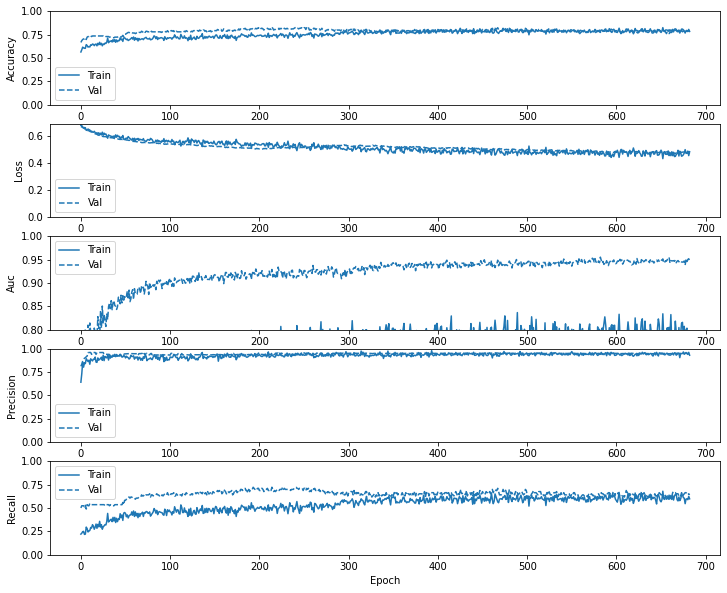

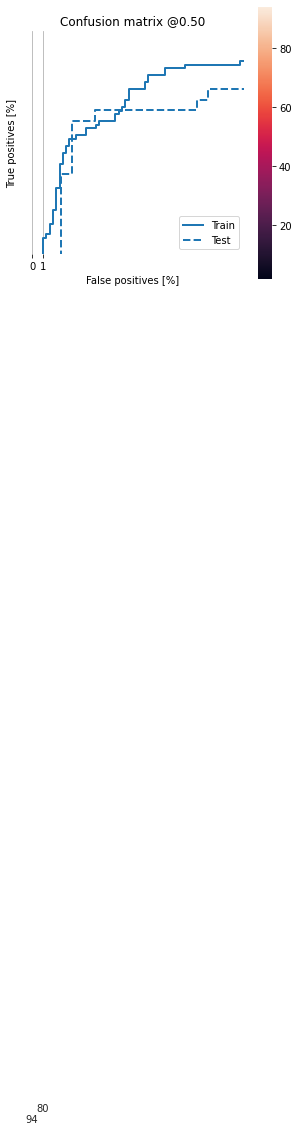

In [19]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 489s 38s/step - loss: 0.7019 - tp: 125.0000 - fp: 50.9286 - tn: 235.5714 - fn: 157.3571 - accuracy: 0.6507 - precision: 0.7244 - recall: 0.4712 - auc: 0.7237 - val_loss: 0.7153 - val_tp: 26.0000 - val_fp: 25.0000 - val_tn: 48.0000 - val_fn: 60.0000 - val_accuracy: 0.4654 - val_precision: 0.5098 - val_recall: 0.3023 - val_auc: 0.4000
Epoch 2/10000
13/13 [==============================] - 488s 38s/step - loss: 0.7033 - tp: 54.0714 - fp: 50.9286 - tn: 141.0000 - fn: 123.8571 - accuracy: 0.5265 - precision: 0.4993 - recall: 0.3039 - auc: 0.4903 - val_loss: 0.7184 - val_tp: 23.0000 - val_fp: 20.0000 - val_tn: 53.0000 - val_fn: 63.0000 - val_accuracy: 0.4780 - val_precision: 0.5349 - val_recall: 0.2674 - val_auc: 0.3616
Epoch 3/10000
13/13 [==============================] - 489s 38s/step - loss: 0.7103 - tp: 46.5714 - fp: 35.8571 - tn: 157.9286 - fn: 129.5000 - accuracy: 0.5634 - precision: 0.5647 - recall: 0.2558 - auc: 0.4934 - val_los

13/13 [==============================] - 489s 38s/step - loss: 0.6884 - tp: 51.2857 - fp: 14.4286 - tn: 173.1429 - fn: 131.0000 - accuracy: 0.6099 - precision: 0.8065 - recall: 0.2891 - auc: 0.5456 - val_loss: 0.7597 - val_tp: 3.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 83.0000 - val_accuracy: 0.4403 - val_precision: 0.3333 - val_recall: 0.0349 - val_auc: 0.2721
Epoch 23/10000
13/13 [==============================] - 489s 38s/step - loss: 0.6841 - tp: 51.2143 - fp: 17.5000 - tn: 170.9286 - fn: 130.2143 - accuracy: 0.5950 - precision: 0.7417 - recall: 0.2807 - auc: 0.5477 - val_loss: 0.7602 - val_tp: 7.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 79.0000 - val_accuracy: 0.4465 - val_precision: 0.4375 - val_recall: 0.0814 - val_auc: 0.2447
Epoch 24/10000
13/13 [==============================] - 490s 38s/step - loss: 0.6790 - tp: 51.8571 - fp: 15.5714 - tn: 178.1429 - fn: 124.2857 - accuracy: 0.6327 - precision: 0.7910 - recall: 0.3155 - auc: 0.5973 - val_loss: 0.7620 - val_t

13/13 [==============================] - 490s 38s/step - loss: 0.6800 - tp: 48.9286 - fp: 12.8571 - tn: 178.9286 - fn: 129.1429 - accuracy: 0.6195 - precision: 0.8171 - recall: 0.2689 - auc: 0.5780 - val_loss: 0.7786 - val_tp: 10.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 76.0000 - val_accuracy: 0.4717 - val_precision: 0.5556 - val_recall: 0.1163 - val_auc: 0.2432
Epoch 44/10000
13/13 [==============================] - 491s 38s/step - loss: 0.6857 - tp: 39.7143 - fp: 6.5000 - tn: 186.7857 - fn: 136.8571 - accuracy: 0.6146 - precision: 0.8244 - recall: 0.2203 - auc: 0.5519 - val_loss: 0.7778 - val_tp: 10.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 76.0000 - val_accuracy: 0.4717 - val_precision: 0.5556 - val_recall: 0.1163 - val_auc: 0.2612
Epoch 45/10000
13/13 [==============================] - 490s 38s/step - loss: 0.6769 - tp: 50.7143 - fp: 8.3571 - tn: 182.9286 - fn: 127.8571 - accuracy: 0.6266 - precision: 0.8491 - recall: 0.2805 - auc: 0.5771 - val_loss: 0.7805 - val_t

Epoch 64/10000
13/13 [==============================] - 490s 38s/step - loss: 0.6765 - tp: 46.6429 - fp: 5.9286 - tn: 185.7143 - fn: 131.5714 - accuracy: 0.6182 - precision: 0.8893 - recall: 0.2460 - auc: 0.5480 - val_loss: 0.7849 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 86.0000 - val_accuracy: 0.4528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1951
Epoch 65/10000
13/13 [==============================] - 490s 38s/step - loss: 0.6736 - tp: 45.8571 - fp: 6.9286 - tn: 184.6429 - fn: 132.4286 - accuracy: 0.6197 - precision: 0.8502 - recall: 0.2527 - auc: 0.5875 - val_loss: 0.7866 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 86.0000 - val_accuracy: 0.4528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1845
Epoch 66/10000
13/13 [==============================] - 490s 38s/step - loss: 0.6779 - tp: 41.0714 - fp: 6.0714 - tn: 186.5714 - fn: 136.1429 - accuracy: 0.6220 - precision: 0.8706 - recall: 0.2425 - au

13/13 [==============================] - 490s 38s/step - loss: 0.6703 - tp: 46.2143 - fp: 6.0714 - tn: 186.9286 - fn: 130.6429 - accuracy: 0.6192 - precision: 0.8664 - recall: 0.2465 - auc: 0.5699 - val_loss: 0.8097 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2173
Epoch 85/10000
13/13 [==============================] - 490s 38s/step - loss: 0.6755 - tp: 44.2143 - fp: 7.5000 - tn: 186.1429 - fn: 132.0000 - accuracy: 0.6228 - precision: 0.8559 - recall: 0.2395 - auc: 0.5522 - val_loss: 0.8134 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 86.0000 - val_accuracy: 0.4528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1795
Epoch 86/10000
13/13 [==============================] - 491s 38s/step - loss: 0.6598 - tp: 48.9286 - fp: 3.5000 - tn: 182.4286 - fn: 135.0000 - accuracy: 0.6206 - precision: 0.9428 - recall: 0.2627 - auc: 0.6332 -

Legitimate Domain Name Detected (True Negatives):  73
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  23
Botnet DGA Missed (False Negatives):  77
Botnet DGA Detected (True Positives):  26
Total Botnet DGAs:  103
CPU times: user 13h 52min 38s, sys: 4min 55s, total: 13h 57min 34s
Wall time: 14h 2min 39s


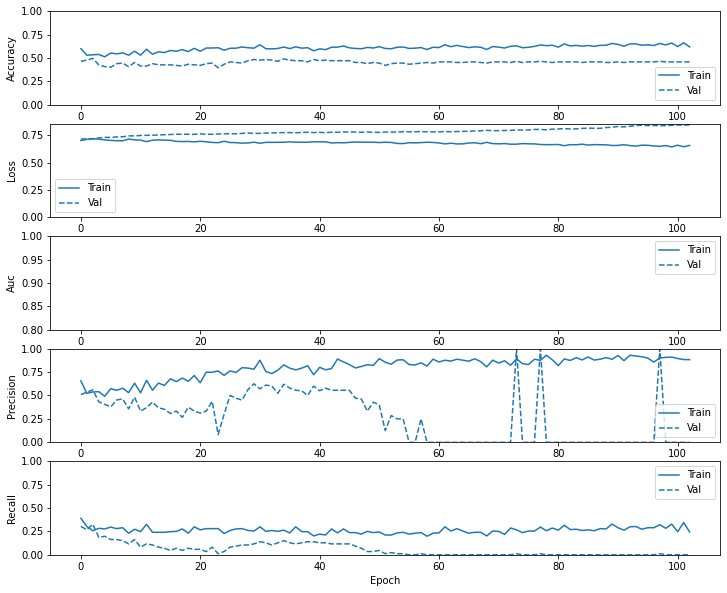

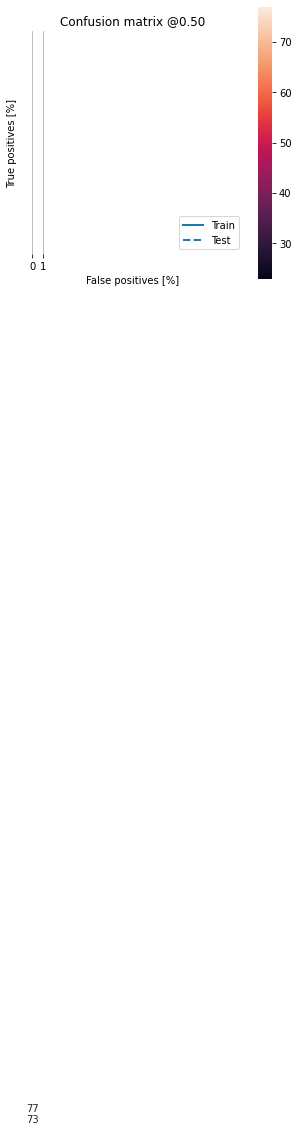

In [20]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 473s 36s/step - loss: 0.7387 - tp: 63.8571 - fp: 77.5000 - tn: 209.0000 - fn: 218.5000 - accuracy: 0.4757 - precision: 0.4475 - recall: 0.2267 - auc: 0.3895 - val_loss: 0.7682 - val_tp: 10.0000 - val_fp: 17.0000 - val_tn: 56.0000 - val_fn: 76.0000 - val_accuracy: 0.4151 - val_precision: 0.3704 - val_recall: 0.1163 - val_auc: 0.2262
Epoch 2/10000
13/13 [==============================] - 472s 36s/step - loss: 0.7321 - tp: 43.5000 - fp: 41.0000 - tn: 150.9286 - fn: 134.4286 - accuracy: 0.5286 - precision: 0.5006 - recall: 0.2346 - auc: 0.4542 - val_loss: 0.7623 - val_tp: 5.0000 - val_fp: 13.0000 - val_tn: 60.0000 - val_fn: 81.0000 - val_accuracy: 0.4088 - val_precision: 0.2778 - val_recall: 0.0581 - val_auc: 0.2241
Epoch 3/10000
13/13 [==============================] - 472s 36s/step - loss: 0.7141 - tp: 52.7143 - fp: 39.1429 - tn: 154.6429 - fn: 123.3571 - accuracy: 0.5614 - precision: 0.5479 - recall: 0.2828 - auc: 0.4862 - val_loss:

13/13 [==============================] - 473s 36s/step - loss: 0.6916 - tp: 48.7857 - fp: 50.6429 - tn: 136.9286 - fn: 133.5000 - accuracy: 0.5023 - precision: 0.5062 - recall: 0.2658 - auc: 0.5184 - val_loss: 0.7005 - val_tp: 21.0000 - val_fp: 17.0000 - val_tn: 56.0000 - val_fn: 65.0000 - val_accuracy: 0.4843 - val_precision: 0.5526 - val_recall: 0.2442 - val_auc: 0.4779
Epoch 23/10000
13/13 [==============================] - 474s 37s/step - loss: 0.7044 - tp: 54.9286 - fp: 51.9286 - tn: 136.5000 - fn: 126.5000 - accuracy: 0.5153 - precision: 0.5195 - recall: 0.2991 - auc: 0.4807 - val_loss: 0.7019 - val_tp: 18.0000 - val_fp: 17.0000 - val_tn: 56.0000 - val_fn: 68.0000 - val_accuracy: 0.4654 - val_precision: 0.5143 - val_recall: 0.2093 - val_auc: 0.4697
Epoch 24/10000
13/13 [==============================] - 473s 36s/step - loss: 0.6986 - tp: 52.7143 - fp: 60.9286 - tn: 132.7857 - fn: 123.4286 - accuracy: 0.5055 - precision: 0.4856 - recall: 0.2927 - auc: 0.4816 - val_loss: 0.6990 - v

13/13 [==============================] - 474s 36s/step - loss: 0.6828 - tp: 48.2143 - fp: 53.5000 - tn: 138.2857 - fn: 129.8571 - accuracy: 0.5169 - precision: 0.4917 - recall: 0.2856 - auc: 0.5483 - val_loss: 0.6845 - val_tp: 24.0000 - val_fp: 16.0000 - val_tn: 57.0000 - val_fn: 62.0000 - val_accuracy: 0.5094 - val_precision: 0.6000 - val_recall: 0.2791 - val_auc: 0.5745
Epoch 44/10000
13/13 [==============================] - 474s 36s/step - loss: 0.6859 - tp: 43.1429 - fp: 52.5000 - tn: 140.7857 - fn: 133.4286 - accuracy: 0.5023 - precision: 0.4386 - recall: 0.2400 - auc: 0.5250 - val_loss: 0.6824 - val_tp: 26.0000 - val_fp: 15.0000 - val_tn: 58.0000 - val_fn: 60.0000 - val_accuracy: 0.5283 - val_precision: 0.6341 - val_recall: 0.3023 - val_auc: 0.5980
Epoch 45/10000
13/13 [==============================] - 474s 37s/step - loss: 0.6816 - tp: 53.2857 - fp: 47.1429 - tn: 144.1429 - fn: 125.2857 - accuracy: 0.5395 - precision: 0.5470 - recall: 0.3022 - auc: 0.5582 - val_loss: 0.6828 - v

13/13 [==============================] - 474s 37s/step - loss: 0.6634 - tp: 58.5000 - fp: 45.1429 - tn: 146.5000 - fn: 119.7143 - accuracy: 0.5534 - precision: 0.5711 - recall: 0.3277 - auc: 0.6191 - val_loss: 0.6541 - val_tp: 30.0000 - val_fp: 10.0000 - val_tn: 63.0000 - val_fn: 56.0000 - val_accuracy: 0.5849 - val_precision: 0.7500 - val_recall: 0.3488 - val_auc: 0.7815
Epoch 65/10000
13/13 [==============================] - 474s 37s/step - loss: 0.6588 - tp: 61.5714 - fp: 52.2143 - tn: 139.3571 - fn: 116.7143 - accuracy: 0.5464 - precision: 0.5434 - recall: 0.3503 - auc: 0.6316 - val_loss: 0.6517 - val_tp: 39.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 47.0000 - val_accuracy: 0.6478 - val_precision: 0.8125 - val_recall: 0.4535 - val_auc: 0.7914
Epoch 66/10000
13/13 [==============================] - 474s 36s/step - loss: 0.6584 - tp: 78.5000 - fp: 49.0000 - tn: 143.6429 - fn: 98.7143 - accuracy: 0.5956 - precision: 0.6011 - recall: 0.4431 - auc: 0.6567 - val_loss: 0.6455 - val

13/13 [==============================] - 474s 36s/step - loss: 0.6252 - tp: 145.7857 - fp: 97.5000 - tn: 96.1429 - fn: 30.4286 - accuracy: 0.6515 - precision: 0.5920 - recall: 0.8408 - auc: 0.6895 - val_loss: 0.5944 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9197
Epoch 86/10000
13/13 [==============================] - 474s 37s/step - loss: 0.6056 - tp: 159.6429 - fp: 87.2857 - tn: 98.6429 - fn: 24.2857 - accuracy: 0.7036 - precision: 0.6557 - recall: 0.8670 - auc: 0.7056 - val_loss: 0.5903 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9303
Epoch 87/10000
13/13 [==============================] - 475s 37s/step - loss: 0.6102 - tp: 150.2857 - fp: 86.5714 - tn: 103.0714 - fn: 29.9286 - accuracy: 0.6888 - precision: 0.6404 - recall: 0.8303 - auc: 0.7234 - val_loss: 0.5895 - val_t

13/13 [==============================] - 474s 37s/step - loss: 0.5952 - tp: 165.5000 - fp: 94.5000 - tn: 93.3571 - fn: 16.5000 - accuracy: 0.7055 - precision: 0.6487 - recall: 0.9031 - auc: 0.7400 - val_loss: 0.5642 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9399
Epoch 107/10000
13/13 [==============================] - 473s 36s/step - loss: 0.5986 - tp: 160.8571 - fp: 92.0714 - tn: 96.9286 - fn: 20.0000 - accuracy: 0.6936 - precision: 0.6328 - recall: 0.8770 - auc: 0.7269 - val_loss: 0.5583 - val_tp: 70.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 16.0000 - val_accuracy: 0.8805 - val_precision: 0.9589 - val_recall: 0.8140 - val_auc: 0.9501
Epoch 108/10000
13/13 [==============================] - 474s 36s/step - loss: 0.6121 - tp: 162.5714 - fp: 100.3571 - tn: 89.2143 - fn: 17.7143 - accuracy: 0.6713 - precision: 0.6077 - recall: 0.9015 - auc: 0.6921 - val_loss: 0.5589 - val

13/13 [==============================] - 474s 37s/step - loss: 0.5903 - tp: 169.3571 - fp: 96.4286 - tn: 90.2857 - fn: 13.7857 - accuracy: 0.7051 - precision: 0.6456 - recall: 0.9286 - auc: 0.7287 - val_loss: 0.5422 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9322
Epoch 128/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5943 - tp: 162.6429 - fp: 98.4286 - tn: 91.8571 - fn: 16.9286 - accuracy: 0.6922 - precision: 0.6294 - recall: 0.9107 - auc: 0.6710 - val_loss: 0.5430 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9390
Epoch 129/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5809 - tp: 173.7143 - fp: 92.3571 - tn: 92.1429 - fn: 11.6429 - accuracy: 0.7218 - precision: 0.6619 - recall: 0.9394 - auc: 0.7243 - val_loss: 0.5381 - val_

13/13 [==============================] - 474s 37s/step - loss: 0.5945 - tp: 163.8571 - fp: 105.8571 - tn: 85.7857 - fn: 14.3571 - accuracy: 0.6692 - precision: 0.6027 - recall: 0.9244 - auc: 0.6696 - val_loss: 0.5260 - val_tp: 73.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 13.0000 - val_accuracy: 0.8868 - val_precision: 0.9359 - val_recall: 0.8488 - val_auc: 0.9385
Epoch 149/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5819 - tp: 171.2857 - fp: 94.9286 - tn: 91.7143 - fn: 11.9286 - accuracy: 0.7047 - precision: 0.6422 - recall: 0.9339 - auc: 0.7159 - val_loss: 0.5254 - val_tp: 73.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 13.0000 - val_accuracy: 0.8931 - val_precision: 0.9481 - val_recall: 0.8488 - val_auc: 0.9325
Epoch 150/10000
13/13 [==============================] - 473s 36s/step - loss: 0.5995 - tp: 157.8571 - fp: 103.8571 - tn: 92.7143 - fn: 15.4286 - accuracy: 0.6674 - precision: 0.5938 - recall: 0.8934 - auc: 0.7042 - val_loss: 0.5276 - va

13/13 [==============================] - 474s 37s/step - loss: 0.5674 - tp: 165.5714 - fp: 95.0714 - tn: 95.9286 - fn: 13.2857 - accuracy: 0.7119 - precision: 0.6421 - recall: 0.9308 - auc: 0.7296 - val_loss: 0.5138 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9508
Epoch 170/10000
13/13 [==============================] - 473s 36s/step - loss: 0.5847 - tp: 161.7143 - fp: 101.6429 - tn: 92.7143 - fn: 13.7857 - accuracy: 0.6848 - precision: 0.6077 - recall: 0.9149 - auc: 0.7018 - val_loss: 0.5142 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9460
Epoch 171/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5682 - tp: 165.4286 - fp: 100.1429 - tn: 94.3571 - fn: 9.9286 - accuracy: 0.7044 - precision: 0.6224 - recall: 0.9526 - auc: 0.7112 - val_loss: 0.5126 - val

13/13 [==============================] - 474s 36s/step - loss: 0.5706 - tp: 160.4286 - fp: 102.5714 - tn: 94.5714 - fn: 12.2857 - accuracy: 0.6911 - precision: 0.6096 - recall: 0.9284 - auc: 0.7214 - val_loss: 0.5033 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9462
Epoch 191/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5771 - tp: 163.1429 - fp: 101.9286 - tn: 91.0714 - fn: 13.7143 - accuracy: 0.6887 - precision: 0.6157 - recall: 0.9213 - auc: 0.7091 - val_loss: 0.4904 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9557
Epoch 192/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5661 - tp: 164.0000 - fp: 96.2143 - tn: 98.1429 - fn: 11.5000 - accuracy: 0.7023 - precision: 0.6215 - recall: 0.9342 - auc: 0.7160 - val_loss: 0.4982 - va

13/13 [==============================] - 474s 37s/step - loss: 0.5829 - tp: 163.1429 - fp: 104.0714 - tn: 87.0714 - fn: 15.5714 - accuracy: 0.6697 - precision: 0.6045 - recall: 0.9154 - auc: 0.7154 - val_loss: 0.4917 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9416
Epoch 212/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5754 - tp: 165.7857 - fp: 103.5714 - tn: 89.8571 - fn: 10.6429 - accuracy: 0.6828 - precision: 0.6106 - recall: 0.9369 - auc: 0.7232 - val_loss: 0.4941 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9506
Epoch 213/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5680 - tp: 170.4286 - fp: 104.5714 - tn: 86.7143 - fn: 8.1429 - accuracy: 0.6941 - precision: 0.6159 - recall: 0.9583 - auc: 0.7194 - val_loss: 0.4883 - va

13/13 [==============================] - 471s 36s/step - loss: 0.5652 - tp: 157.6429 - fp: 99.1429 - tn: 98.0714 - fn: 15.0000 - accuracy: 0.6911 - precision: 0.6130 - recall: 0.9133 - auc: 0.6950 - val_loss: 0.4819 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9450
Epoch 233/10000
13/13 [==============================] - 474s 36s/step - loss: 0.5772 - tp: 164.2143 - fp: 103.0000 - tn: 88.6429 - fn: 14.0000 - accuracy: 0.6812 - precision: 0.6079 - recall: 0.9281 - auc: 0.6970 - val_loss: 0.4855 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9479
Epoch 234/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5838 - tp: 163.4286 - fp: 106.5000 - tn: 87.0000 - fn: 12.9286 - accuracy: 0.6648 - precision: 0.5879 - recall: 0.9277 - auc: 0.7090 - val_loss: 0.4907 - val

13/13 [==============================] - 474s 37s/step - loss: 0.5844 - tp: 161.5000 - fp: 106.6429 - tn: 87.1429 - fn: 14.5714 - accuracy: 0.6662 - precision: 0.5928 - recall: 0.9221 - auc: 0.6596 - val_loss: 0.4813 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9429
Epoch 254/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5458 - tp: 167.7143 - fp: 89.2857 - tn: 100.6429 - fn: 12.2143 - accuracy: 0.7253 - precision: 0.6460 - recall: 0.9437 - auc: 0.7089 - val_loss: 0.4810 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9518
Epoch 255/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5749 - tp: 162.7143 - fp: 99.6429 - tn: 89.9286 - fn: 17.5714 - accuracy: 0.6835 - precision: 0.6193 - recall: 0.9015 - auc: 0.7172 - val_loss: 0.4843 - val

13/13 [==============================] - 475s 37s/step - loss: 0.5999 - tp: 160.7857 - fp: 116.2143 - tn: 82.5000 - fn: 10.3571 - accuracy: 0.6347 - precision: 0.5485 - recall: 0.9331 - auc: 0.6712 - val_loss: 0.4726 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9393
Epoch 275/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5341 - tp: 166.7857 - fp: 86.5714 - tn: 104.5000 - fn: 12.0000 - accuracy: 0.7310 - precision: 0.6579 - recall: 0.9288 - auc: 0.7610 - val_loss: 0.4735 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9393
Epoch 276/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5809 - tp: 169.6429 - fp: 110.8571 - tn: 78.3571 - fn: 11.0000 - accuracy: 0.6788 - precision: 0.6117 - recall: 0.9475 - auc: 0.6713 - val_loss: 0.4769 - v

13/13 [==============================] - 474s 37s/step - loss: 0.5829 - tp: 169.7857 - fp: 106.5000 - tn: 82.6429 - fn: 10.9286 - accuracy: 0.6691 - precision: 0.6024 - recall: 0.9384 - auc: 0.6925 - val_loss: 0.4727 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9276
Epoch 296/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5587 - tp: 169.0714 - fp: 95.5714 - tn: 95.7143 - fn: 9.5000 - accuracy: 0.7172 - precision: 0.6401 - recall: 0.9530 - auc: 0.7225 - val_loss: 0.4686 - val_tp: 78.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9119 - val_precision: 0.9286 - val_recall: 0.9070 - val_auc: 0.9417
Epoch 297/10000
13/13 [==============================] - 474s 37s/step - loss: 0.5617 - tp: 161.2143 - fp: 100.4286 - tn: 92.1429 - fn: 16.0714 - accuracy: 0.6868 - precision: 0.6191 - recall: 0.9137 - auc: 0.7093 - val_loss: 0.4726 - val_t

13/13 [==============================] - 474s 36s/step - loss: 0.5949 - tp: 171.7143 - fp: 115.9286 - tn: 74.5000 - fn: 7.7143 - accuracy: 0.6639 - precision: 0.6014 - recall: 0.9497 - auc: 0.6561 - val_loss: 0.4725 - val_tp: 77.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 9.0000 - val_accuracy: 0.8931 - val_precision: 0.9059 - val_recall: 0.8953 - val_auc: 0.9325
Epoch 317/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5561 - tp: 166.2857 - fp: 102.2143 - tn: 91.5714 - fn: 9.7857 - accuracy: 0.6992 - precision: 0.6160 - recall: 0.9501 - auc: 0.6992 - val_loss: 0.4657 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9398
Epoch 318/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5806 - tp: 160.0000 - fp: 103.5000 - tn: 91.2143 - fn: 15.1429 - accuracy: 0.6770 - precision: 0.6088 - recall: 0.9057 - auc: 0.7081 - val_loss: 0.4747 - val_t

13/13 [==============================] - 474s 36s/step - loss: 0.5477 - tp: 159.7143 - fp: 98.5714 - tn: 101.3571 - fn: 10.2143 - accuracy: 0.6995 - precision: 0.6100 - recall: 0.9293 - auc: 0.7325 - val_loss: 0.4653 - val_tp: 78.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 8.0000 - val_accuracy: 0.8994 - val_precision: 0.9070 - val_recall: 0.9070 - val_auc: 0.9540
Epoch 338/10000
13/13 [==============================] - 474s 36s/step - loss: 0.5417 - tp: 166.4286 - fp: 101.6429 - tn: 94.7857 - fn: 7.0000 - accuracy: 0.7065 - precision: 0.6151 - recall: 0.9648 - auc: 0.7482 - val_loss: 0.4652 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9364
Epoch 339/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5491 - tp: 168.6429 - fp: 96.8571 - tn: 91.7857 - fn: 12.5714 - accuracy: 0.7090 - precision: 0.6448 - recall: 0.9298 - auc: 0.7645 - val_loss: 0.4609 - val_t

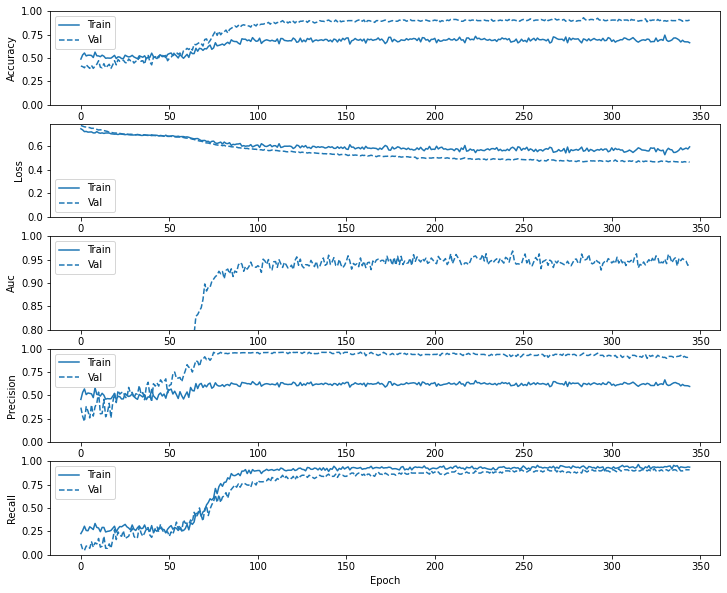

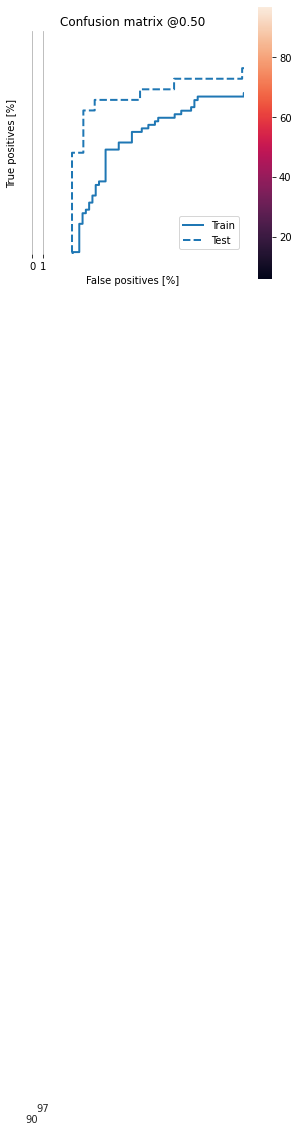

In [21]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 946s 73s/step - loss: 0.7255 - tp: 256.3571 - fp: 192.2143 - tn: 94.2857 - fn: 26.0000 - accuracy: 0.6434 - precision: 0.5987 - recall: 0.9112 - auc: 0.6970 - val_loss: 0.7293 - val_tp: 66.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 20.0000 - val_accuracy: 0.4151 - val_precision: 0.4748 - val_recall: 0.7674 - val_auc: 0.2686
Epoch 2/10000
13/13 [==============================] - 946s 73s/step - loss: 0.7323 - tp: 153.4286 - fp: 190.7143 - tn: 1.2143 - fn: 24.5000 - accuracy: 0.4137 - precision: 0.4396 - recall: 0.8699 - auc: 0.4016 - val_loss: 0.7255 - val_tp: 66.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 20.0000 - val_accuracy: 0.4151 - val_precision: 0.4748 - val_recall: 0.7674 - val_auc: 0.2850
Epoch 3/10000
13/13 [==============================] - 946s 73s/step - loss: 0.7345 - tp: 147.7857 - fp: 193.3571 - tn: 0.4286 - fn: 28.2857 - accuracy: 0.3925 - precision: 0.4229 - recall: 0.8448 - auc: 0.3916 - val_

13/13 [==============================] - 946s 73s/step - loss: 0.6997 - tp: 74.6429 - fp: 72.5000 - tn: 115.0714 - fn: 107.6429 - accuracy: 0.5019 - precision: 0.5030 - recall: 0.3991 - auc: 0.4991 - val_loss: 0.7132 - val_tp: 22.0000 - val_fp: 31.0000 - val_tn: 42.0000 - val_fn: 64.0000 - val_accuracy: 0.4025 - val_precision: 0.4151 - val_recall: 0.2558 - val_auc: 0.3071
Epoch 23/10000
13/13 [==============================] - 946s 73s/step - loss: 0.6910 - tp: 85.2857 - fp: 60.5714 - tn: 127.8571 - fn: 96.1429 - accuracy: 0.5900 - precision: 0.6048 - recall: 0.4910 - auc: 0.5881 - val_loss: 0.7115 - val_tp: 23.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 63.0000 - val_accuracy: 0.4906 - val_precision: 0.5610 - val_recall: 0.2674 - val_auc: 0.3531
Epoch 24/10000
13/13 [==============================] - 946s 73s/step - loss: 0.6967 - tp: 66.2857 - fp: 58.0714 - tn: 135.6429 - fn: 109.8571 - accuracy: 0.5356 - precision: 0.5267 - recall: 0.3861 - auc: 0.5153 - val_loss: 0.7162 - va

13/13 [==============================] - 948s 73s/step - loss: 0.6852 - tp: 49.4286 - fp: 3.7857 - tn: 188.0000 - fn: 128.6429 - accuracy: 0.6563 - precision: 0.9256 - recall: 0.3081 - auc: 0.5860 - val_loss: 0.7132 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 74.0000 - val_accuracy: 0.5157 - val_precision: 0.8000 - val_recall: 0.1395 - val_auc: 0.3254
Epoch 44/10000
13/13 [==============================] - 949s 73s/step - loss: 0.6853 - tp: 48.5000 - fp: 7.8571 - tn: 185.4286 - fn: 128.0714 - accuracy: 0.6566 - precision: 0.8714 - recall: 0.3132 - auc: 0.6055 - val_loss: 0.7116 - val_tp: 13.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 73.0000 - val_accuracy: 0.5220 - val_precision: 0.8125 - val_recall: 0.1512 - val_auc: 0.3453
Epoch 45/10000
13/13 [==============================] - 948s 73s/step - loss: 0.6948 - tp: 37.7857 - fp: 6.0000 - tn: 185.2857 - fn: 140.7857 - accuracy: 0.5978 - precision: 0.8522 - recall: 0.2070 - auc: 0.5445 - val_loss: 0.7136 - val_tp

13/13 [==============================] - 948s 73s/step - loss: 0.6894 - tp: 41.2143 - fp: 5.8571 - tn: 185.7857 - fn: 137.0000 - accuracy: 0.6163 - precision: 0.8805 - recall: 0.2420 - auc: 0.5347 - val_loss: 0.7151 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3360
Epoch 65/10000
13/13 [==============================] - 947s 73s/step - loss: 0.6862 - tp: 41.5000 - fp: 6.5000 - tn: 185.0714 - fn: 136.7857 - accuracy: 0.6100 - precision: 0.8540 - recall: 0.2273 - auc: 0.5603 - val_loss: 0.7120 - val_tp: 15.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 71.0000 - val_accuracy: 0.5283 - val_precision: 0.7895 - val_recall: 0.1744 - val_auc: 0.3448
Epoch 66/10000
13/13 [==============================] - 949s 73s/step - loss: 0.6830 - tp: 48.5000 - fp: 5.2857 - tn: 187.3571 - fn: 128.7143 - accuracy: 0.6461 - precision: 0.9044 - recall: 0.2860 - auc: 0.5777 - val_loss: 0.7139 - val_tp

13/13 [==============================] - 949s 73s/step - loss: 0.6577 - tp: 58.1429 - fp: 2.7143 - tn: 190.9286 - fn: 118.0714 - accuracy: 0.6829 - precision: 0.9644 - recall: 0.3392 - auc: 0.6676 - val_loss: 0.7287 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3116
Epoch 86/10000
13/13 [==============================] - 949s 73s/step - loss: 0.6652 - tp: 58.0714 - fp: 3.5714 - tn: 182.3571 - fn: 125.8571 - accuracy: 0.6460 - precision: 0.9579 - recall: 0.3113 - auc: 0.6111 - val_loss: 0.7264 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3345
Epoch 87/10000
13/13 [==============================] - 948s 73s/step - loss: 0.6718 - tp: 44.2857 - fp: 3.5000 - tn: 186.1429 - fn: 135.9286 - accuracy: 0.6174 - precision: 0.9117 - recall: 0.2381 - auc: 0.6000 - val_loss: 0.7292 - val_tp

13/13 [==============================] - 950s 73s/step - loss: 0.6313 - tp: 66.5000 - fp: 3.2143 - tn: 184.6429 - fn: 115.5000 - accuracy: 0.6803 - precision: 0.9513 - recall: 0.3811 - auc: 0.6759 - val_loss: 0.7649 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3862
Epoch 107/10000
13/13 [==============================] - 949s 73s/step - loss: 0.6272 - tp: 59.7143 - fp: 2.5000 - tn: 186.5000 - fn: 121.1429 - accuracy: 0.6733 - precision: 0.9651 - recall: 0.3412 - auc: 0.6475 - val_loss: 0.7709 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3422
Epoch 108/10000
13/13 [==============================] - 948s 73s/step - loss: 0.6293 - tp: 61.0714 - fp: 6.0714 - tn: 183.5000 - fn: 119.2143 - accuracy: 0.6717 - precision: 0.9151 - recall: 0.3546 - auc: 0.6706 - val_loss: 0.7726 - val_

13/13 [==============================] - 949s 73s/step - loss: 0.5810 - tp: 68.7143 - fp: 4.6429 - tn: 182.0714 - fn: 114.4286 - accuracy: 0.6792 - precision: 0.9436 - recall: 0.3895 - auc: 0.7514 - val_loss: 0.8149 - val_tp: 13.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 73.0000 - val_accuracy: 0.5220 - val_precision: 0.8125 - val_recall: 0.1512 - val_auc: 0.3575
Epoch 128/10000
13/13 [==============================] - 948s 73s/step - loss: 0.5995 - tp: 64.3571 - fp: 5.6429 - tn: 184.6429 - fn: 115.2143 - accuracy: 0.6634 - precision: 0.9109 - recall: 0.3509 - auc: 0.7328 - val_loss: 0.8132 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3560
Epoch 129/10000
13/13 [==============================] - 948s 73s/step - loss: 0.6048 - tp: 65.0714 - fp: 6.7857 - tn: 177.7143 - fn: 120.2857 - accuracy: 0.6462 - precision: 0.9238 - recall: 0.3440 - auc: 0.7016 - val_loss: 0.8122 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.5870 - tp: 71.2857 - fp: 6.5714 - tn: 185.0714 - fn: 106.9286 - accuracy: 0.6829 - precision: 0.9010 - recall: 0.3845 - auc: 0.7497 - val_loss: 0.7748 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.4538
Epoch 149/10000
13/13 [==============================] - 948s 73s/step - loss: 0.5975 - tp: 70.8571 - fp: 4.7857 - tn: 181.8571 - fn: 112.3571 - accuracy: 0.6742 - precision: 0.9306 - recall: 0.3818 - auc: 0.7154 - val_loss: 0.7786 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.4235
Epoch 150/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5791 - tp: 63.6429 - fp: 6.9286 - tn: 189.6429 - fn: 109.6429 - accuracy: 0.6904 - precision: 0.9130 - recall: 0.3678 - auc: 0.7275 - val_loss: 0.7754 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.5888 - tp: 75.0714 - fp: 8.8571 - tn: 182.1429 - fn: 103.7857 - accuracy: 0.6933 - precision: 0.9125 - recall: 0.4149 - auc: 0.7542 - val_loss: 0.6979 - val_tp: 24.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 62.0000 - val_accuracy: 0.5912 - val_precision: 0.8889 - val_recall: 0.2791 - val_auc: 0.6658
Epoch 170/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5838 - tp: 69.0000 - fp: 6.5000 - tn: 187.8571 - fn: 106.5000 - accuracy: 0.6897 - precision: 0.9146 - recall: 0.3696 - auc: 0.7595 - val_loss: 0.6965 - val_tp: 21.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 65.0000 - val_accuracy: 0.5723 - val_precision: 0.8750 - val_recall: 0.2442 - val_auc: 0.6892
Epoch 171/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5575 - tp: 74.2143 - fp: 6.0000 - tn: 188.5000 - fn: 101.1429 - accuracy: 0.7170 - precision: 0.9358 - recall: 0.4304 - auc: 0.7895 - val_loss: 0.6872 - val_

13/13 [==============================] - 948s 73s/step - loss: 0.5652 - tp: 78.5000 - fp: 9.6429 - tn: 187.5000 - fn: 94.2143 - accuracy: 0.7152 - precision: 0.8879 - recall: 0.4423 - auc: 0.7706 - val_loss: 0.6258 - val_tp: 40.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 46.0000 - val_accuracy: 0.6918 - val_precision: 0.9302 - val_recall: 0.4651 - val_auc: 0.8433
Epoch 191/10000
13/13 [==============================] - 948s 73s/step - loss: 0.5334 - tp: 91.2857 - fp: 8.5000 - tn: 184.5000 - fn: 85.5714 - accuracy: 0.7521 - precision: 0.9130 - recall: 0.5306 - auc: 0.8016 - val_loss: 0.6268 - val_tp: 42.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 44.0000 - val_accuracy: 0.7044 - val_precision: 0.9333 - val_recall: 0.4884 - val_auc: 0.8229
Epoch 192/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5180 - tp: 95.7857 - fp: 5.6429 - tn: 188.7143 - fn: 79.7143 - accuracy: 0.7756 - precision: 0.9553 - recall: 0.5475 - auc: 0.8122 - val_loss: 0.6251 - val_tp:

13/13 [==============================] - 947s 73s/step - loss: 0.5428 - tp: 97.8571 - fp: 5.3571 - tn: 185.7857 - fn: 80.8571 - accuracy: 0.7597 - precision: 0.9459 - recall: 0.5328 - auc: 0.7939 - val_loss: 0.5781 - val_tp: 48.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 38.0000 - val_accuracy: 0.7421 - val_precision: 0.9412 - val_recall: 0.5581 - val_auc: 0.8930
Epoch 212/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5484 - tp: 92.9286 - fp: 10.1429 - tn: 183.2857 - fn: 83.5000 - accuracy: 0.7506 - precision: 0.9042 - recall: 0.5374 - auc: 0.7748 - val_loss: 0.5822 - val_tp: 50.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 36.0000 - val_accuracy: 0.7547 - val_precision: 0.9434 - val_recall: 0.5814 - val_auc: 0.8877
Epoch 213/10000
13/13 [==============================] - 945s 73s/step - loss: 0.5488 - tp: 98.0714 - fp: 7.7143 - tn: 183.5714 - fn: 80.5000 - accuracy: 0.7603 - precision: 0.9329 - recall: 0.5377 - auc: 0.7709 - val_loss: 0.5816 - val_tp

13/13 [==============================] - 947s 73s/step - loss: 0.5294 - tp: 94.8571 - fp: 8.9286 - tn: 188.2857 - fn: 77.7857 - accuracy: 0.7732 - precision: 0.9181 - recall: 0.5602 - auc: 0.7707 - val_loss: 0.5473 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.9122
Epoch 233/10000
13/13 [==============================] - 948s 73s/step - loss: 0.5531 - tp: 88.0714 - fp: 8.5000 - tn: 183.1429 - fn: 90.1429 - accuracy: 0.7370 - precision: 0.9136 - recall: 0.4931 - auc: 0.7619 - val_loss: 0.5446 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9233
Epoch 234/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5231 - tp: 99.5000 - fp: 6.9286 - tn: 186.5714 - fn: 76.8571 - accuracy: 0.7778 - precision: 0.9284 - recall: 0.5640 - auc: 0.7941 - val_loss: 0.5442 - val_tp:

13/13 [==============================] - 947s 73s/step - loss: 0.5139 - tp: 101.3571 - fp: 4.5000 - tn: 189.2857 - fn: 74.7143 - accuracy: 0.7874 - precision: 0.9483 - recall: 0.5794 - auc: 0.7728 - val_loss: 0.5221 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9308
Epoch 254/10000
13/13 [==============================] - 948s 73s/step - loss: 0.4867 - tp: 109.4286 - fp: 5.2143 - tn: 184.7143 - fn: 70.5000 - accuracy: 0.8017 - precision: 0.9598 - recall: 0.6118 - auc: 0.8084 - val_loss: 0.5241 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9234
Epoch 255/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4946 - tp: 108.2857 - fp: 5.4286 - tn: 184.1429 - fn: 72.0000 - accuracy: 0.7962 - precision: 0.9586 - recall: 0.6067 - auc: 0.8014 - val_loss: 0.5221 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.4825 - tp: 103.6429 - fp: 8.4286 - tn: 190.2857 - fn: 67.5000 - accuracy: 0.8116 - precision: 0.9084 - recall: 0.6425 - auc: 0.8065 - val_loss: 0.5139 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9292
Epoch 275/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4945 - tp: 109.2857 - fp: 6.3571 - tn: 184.7143 - fn: 69.5000 - accuracy: 0.8027 - precision: 0.9531 - recall: 0.6235 - auc: 0.7955 - val_loss: 0.5109 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9333
Epoch 276/10000
13/13 [==============================] - 946s 73s/step - loss: 0.5298 - tp: 107.0000 - fp: 6.0000 - tn: 183.2143 - fn: 73.6429 - accuracy: 0.7768 - precision: 0.9443 - recall: 0.5799 - auc: 0.7822 - val_loss: 0.5068 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.4970 - tp: 111.6429 - fp: 10.7857 - tn: 178.3571 - fn: 69.0714 - accuracy: 0.7861 - precision: 0.9023 - recall: 0.6278 - auc: 0.7897 - val_loss: 0.4967 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9429
Epoch 296/10000
13/13 [==============================] - 948s 73s/step - loss: 0.4882 - tp: 113.0000 - fp: 8.3571 - tn: 182.9286 - fn: 65.5714 - accuracy: 0.7977 - precision: 0.9279 - recall: 0.6330 - auc: 0.8086 - val_loss: 0.4978 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9385
Epoch 297/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4909 - tp: 106.0714 - fp: 5.6429 - tn: 186.9286 - fn: 71.2143 - accuracy: 0.7934 - precision: 0.9519 - recall: 0.6019 - auc: 0.7933 - val_loss: 0.5030 - val

13/13 [==============================] - 947s 73s/step - loss: 0.4946 - tp: 110.5000 - fp: 7.7857 - tn: 182.6429 - fn: 68.9286 - accuracy: 0.7769 - precision: 0.9261 - recall: 0.5989 - auc: 0.7960 - val_loss: 0.4910 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9423
Epoch 317/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4667 - tp: 110.7857 - fp: 2.4286 - tn: 191.3571 - fn: 65.2857 - accuracy: 0.8245 - precision: 0.9850 - recall: 0.6356 - auc: 0.8406 - val_loss: 0.4894 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9375
Epoch 318/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4956 - tp: 104.7857 - fp: 6.5000 - tn: 188.2143 - fn: 70.3571 - accuracy: 0.7946 - precision: 0.9522 - recall: 0.6000 - auc: 0.7751 - val_loss: 0.4937 - val_

13/13 [==============================] - 946s 73s/step - loss: 0.5094 - tp: 97.2857 - fp: 8.3571 - tn: 191.5714 - fn: 72.6429 - accuracy: 0.7779 - precision: 0.9121 - recall: 0.5632 - auc: 0.7698 - val_loss: 0.4880 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9345
Epoch 338/10000
13/13 [==============================] - 946s 73s/step - loss: 0.5097 - tp: 97.5714 - fp: 8.7143 - tn: 187.7143 - fn: 75.8571 - accuracy: 0.7750 - precision: 0.9215 - recall: 0.5582 - auc: 0.7733 - val_loss: 0.4864 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9423
Epoch 339/10000
13/13 [==============================] - 945s 73s/step - loss: 0.4973 - tp: 112.2857 - fp: 6.2143 - tn: 182.4286 - fn: 68.9286 - accuracy: 0.7862 - precision: 0.9525 - recall: 0.6070 - auc: 0.7969 - val_loss: 0.4803 - val_tp

13/13 [==============================] - 947s 73s/step - loss: 0.5021 - tp: 101.7857 - fp: 5.5000 - tn: 185.5714 - fn: 77.0000 - accuracy: 0.7813 - precision: 0.9587 - recall: 0.5722 - auc: 0.7758 - val_loss: 0.4814 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9408
Epoch 359/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4804 - tp: 111.0000 - fp: 6.2143 - tn: 181.2857 - fn: 71.3571 - accuracy: 0.7885 - precision: 0.9527 - recall: 0.6033 - auc: 0.8100 - val_loss: 0.4811 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9353
Epoch 360/10000
13/13 [==============================] - 946s 73s/step - loss: 0.5294 - tp: 102.7857 - fp: 9.7143 - tn: 179.2857 - fn: 78.0714 - accuracy: 0.7588 - precision: 0.9121 - recall: 0.5615 - auc: 0.7626 - val_loss: 0.4798 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.4812 - tp: 109.0000 - fp: 5.3571 - tn: 186.7857 - fn: 68.7143 - accuracy: 0.8003 - precision: 0.9545 - recall: 0.6185 - auc: 0.7929 - val_loss: 0.4723 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9448
Epoch 380/10000
13/13 [==============================] - 946s 73s/step - loss: 0.5046 - tp: 99.2143 - fp: 7.6429 - tn: 186.9286 - fn: 76.0714 - accuracy: 0.7713 - precision: 0.9182 - recall: 0.5639 - auc: 0.7659 - val_loss: 0.4751 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9445
Epoch 381/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4605 - tp: 110.3571 - fp: 4.5714 - tn: 189.5714 - fn: 65.3571 - accuracy: 0.8135 - precision: 0.9643 - recall: 0.6338 - auc: 0.8157 - val_loss: 0.4737 - val_t

13/13 [==============================] - 948s 73s/step - loss: 0.4985 - tp: 107.2143 - fp: 6.4286 - tn: 183.7857 - fn: 72.4286 - accuracy: 0.7717 - precision: 0.9382 - recall: 0.5816 - auc: 0.8098 - val_loss: 0.4643 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9417
Epoch 401/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4639 - tp: 108.0000 - fp: 6.8571 - tn: 186.7143 - fn: 68.2857 - accuracy: 0.8034 - precision: 0.9454 - recall: 0.6239 - auc: 0.8154 - val_loss: 0.4675 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9431
Epoch 402/10000
13/13 [==============================] - 946s 73s/step - loss: 0.5042 - tp: 107.3571 - fp: 7.5714 - tn: 184.0000 - fn: 70.9286 - accuracy: 0.7772 - precision: 0.9312 - recall: 0.5858 - auc: 0.7618 - val_loss: 0.4693 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.4691 - tp: 108.0000 - fp: 6.7143 - tn: 188.1429 - fn: 67.0000 - accuracy: 0.8071 - precision: 0.9449 - recall: 0.6222 - auc: 0.7878 - val_loss: 0.4652 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9382
Epoch 422/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4867 - tp: 111.9286 - fp: 8.5714 - tn: 183.4286 - fn: 65.9286 - accuracy: 0.7897 - precision: 0.9070 - recall: 0.6166 - auc: 0.7972 - val_loss: 0.4664 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9364
Epoch 423/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5350 - tp: 101.6429 - fp: 7.7857 - tn: 175.8571 - fn: 84.5714 - accuracy: 0.7372 - precision: 0.9235 - recall: 0.5396 - auc: 0.7697 - val_loss: 0.4670 - val_

13/13 [==============================] - 946s 73s/step - loss: 0.5085 - tp: 102.5714 - fp: 7.8571 - tn: 181.2143 - fn: 78.2143 - accuracy: 0.7642 - precision: 0.9248 - recall: 0.5600 - auc: 0.7529 - val_loss: 0.4656 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9352
Epoch 443/10000
13/13 [==============================] - 948s 73s/step - loss: 0.4808 - tp: 111.5714 - fp: 11.5714 - tn: 180.0714 - fn: 66.6429 - accuracy: 0.7857 - precision: 0.9003 - recall: 0.6313 - auc: 0.8045 - val_loss: 0.4606 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9541
Epoch 444/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4748 - tp: 107.2143 - fp: 9.5000 - tn: 186.0714 - fn: 67.0714 - accuracy: 0.8002 - precision: 0.9132 - recall: 0.6334 - auc: 0.8069 - val_loss: 0.4601 - val

13/13 [==============================] - 945s 73s/step - loss: 0.4833 - tp: 99.5714 - fp: 4.6429 - tn: 187.6429 - fn: 78.0000 - accuracy: 0.7834 - precision: 0.9617 - recall: 0.5723 - auc: 0.7896 - val_loss: 0.4548 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9450
Epoch 464/10000
13/13 [==============================] - 944s 73s/step - loss: 0.4805 - tp: 107.5000 - fp: 8.6429 - tn: 179.9286 - fn: 73.7857 - accuracy: 0.7794 - precision: 0.9267 - recall: 0.5978 - auc: 0.8157 - val_loss: 0.4554 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9468
Epoch 465/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4409 - tp: 117.5714 - fp: 6.5000 - tn: 187.0714 - fn: 58.7143 - accuracy: 0.8280 - precision: 0.9482 - recall: 0.6695 - auc: 0.8198 - val_loss: 0.4587 - val_t

13/13 [==============================] - 947s 73s/step - loss: 0.4951 - tp: 111.2143 - fp: 8.0714 - tn: 171.5000 - fn: 79.0714 - accuracy: 0.7570 - precision: 0.9287 - recall: 0.5825 - auc: 0.7956 - val_loss: 0.4528 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9496
Epoch 485/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4825 - tp: 110.8571 - fp: 6.9286 - tn: 183.5000 - fn: 68.5714 - accuracy: 0.7882 - precision: 0.9347 - recall: 0.5998 - auc: 0.7923 - val_loss: 0.4543 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9431
Epoch 486/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4680 - tp: 108.9286 - fp: 8.3571 - tn: 187.2857 - fn: 65.2857 - accuracy: 0.7954 - precision: 0.9193 - recall: 0.6251 - auc: 0.8189 - val_loss: 0.4551 - val_

13/13 [==============================] - 945s 73s/step - loss: 0.4949 - tp: 110.2143 - fp: 6.7143 - tn: 176.9286 - fn: 76.0000 - accuracy: 0.7565 - precision: 0.9308 - recall: 0.5784 - auc: 0.7890 - val_loss: 0.4565 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9437
Epoch 506/10000
13/13 [==============================] - 944s 73s/step - loss: 0.4760 - tp: 112.3571 - fp: 5.7857 - tn: 184.5000 - fn: 67.2143 - accuracy: 0.8003 - precision: 0.9475 - recall: 0.6108 - auc: 0.7915 - val_loss: 0.4550 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9455
Epoch 507/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4737 - tp: 110.2857 - fp: 7.6429 - tn: 185.8571 - fn: 66.0714 - accuracy: 0.8011 - precision: 0.9303 - recall: 0.6217 - auc: 0.7976 - val_loss: 0.4537 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.4898 - tp: 103.9286 - fp: 9.5000 - tn: 182.7143 - fn: 73.7143 - accuracy: 0.7694 - precision: 0.9083 - recall: 0.5839 - auc: 0.7811 - val_loss: 0.4499 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9392
Epoch 527/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4799 - tp: 109.2857 - fp: 7.4286 - tn: 184.4286 - fn: 68.7143 - accuracy: 0.7919 - precision: 0.9408 - recall: 0.6032 - auc: 0.7824 - val_loss: 0.4472 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9497
Epoch 528/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4513 - tp: 113.7857 - fp: 4.5000 - tn: 187.0714 - fn: 64.5000 - accuracy: 0.8182 - precision: 0.9672 - recall: 0.6487 - auc: 0.8239 - val_loss: 0.4462 - val_

13/13 [==============================] - 945s 73s/step - loss: 0.4572 - tp: 119.0714 - fp: 10.6429 - tn: 179.8571 - fn: 60.2857 - accuracy: 0.8051 - precision: 0.9128 - recall: 0.6671 - auc: 0.8371 - val_loss: 0.4469 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9411
Epoch 548/10000
13/13 [==============================] - 945s 73s/step - loss: 0.4420 - tp: 111.7143 - fp: 5.7143 - tn: 188.5714 - fn: 63.8571 - accuracy: 0.8252 - precision: 0.9569 - recall: 0.6589 - auc: 0.8287 - val_loss: 0.4433 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9429
Epoch 549/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4911 - tp: 107.5714 - fp: 8.4286 - tn: 179.3571 - fn: 74.5000 - accuracy: 0.7676 - precision: 0.9237 - recall: 0.5709 - auc: 0.7767 - val_loss: 0.4430 - val

13/13 [==============================] - 946s 73s/step - loss: 0.4754 - tp: 109.7143 - fp: 6.1429 - tn: 183.5714 - fn: 70.4286 - accuracy: 0.7917 - precision: 0.9586 - recall: 0.5987 - auc: 0.7949 - val_loss: 0.4421 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9474
Epoch 569/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5012 - tp: 99.9286 - fp: 6.9286 - tn: 184.1429 - fn: 78.8571 - accuracy: 0.7686 - precision: 0.9396 - recall: 0.5444 - auc: 0.7531 - val_loss: 0.4436 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9476
Epoch 570/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4690 - tp: 112.0000 - fp: 8.9286 - tn: 179.5714 - fn: 69.3571 - accuracy: 0.7881 - precision: 0.9322 - recall: 0.6150 - auc: 0.8076 - val_loss: 0.4443 - val_t

13/13 [==============================] - 948s 73s/step - loss: 0.4523 - tp: 112.3571 - fp: 5.8571 - tn: 188.9286 - fn: 62.7143 - accuracy: 0.8153 - precision: 0.9570 - recall: 0.6255 - auc: 0.8055 - val_loss: 0.4376 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9510
Epoch 590/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4840 - tp: 113.5714 - fp: 8.9286 - tn: 177.5000 - fn: 69.8571 - accuracy: 0.7948 - precision: 0.9356 - recall: 0.6312 - auc: 0.7887 - val_loss: 0.4410 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9417
Epoch 591/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4429 - tp: 111.0000 - fp: 5.4286 - tn: 189.1429 - fn: 64.2857 - accuracy: 0.8178 - precision: 0.9607 - recall: 0.6409 - auc: 0.8006 - val_loss: 0.4361 - val_

13/13 [==============================] - 947s 73s/step - loss: 0.5078 - tp: 99.3571 - fp: 8.7857 - tn: 187.9286 - fn: 73.7857 - accuracy: 0.7655 - precision: 0.9178 - recall: 0.5486 - auc: 0.7783 - val_loss: 0.4408 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9497
Epoch 611/10000
13/13 [==============================] - 947s 73s/step - loss: 0.5099 - tp: 100.0000 - fp: 7.0000 - tn: 185.4286 - fn: 77.4286 - accuracy: 0.7567 - precision: 0.9237 - recall: 0.5408 - auc: 0.7502 - val_loss: 0.4367 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9478
Epoch 612/10000
13/13 [==============================] - 948s 73s/step - loss: 0.4446 - tp: 107.1429 - fp: 4.5000 - tn: 191.7857 - fn: 66.4286 - accuracy: 0.8242 - precision: 0.9639 - recall: 0.6404 - auc: 0.8221 - val_loss: 0.4399 - val_t

13/13 [==============================] - 948s 73s/step - loss: 0.4982 - tp: 104.0000 - fp: 7.2143 - tn: 185.0714 - fn: 73.5714 - accuracy: 0.7790 - precision: 0.9303 - recall: 0.5778 - auc: 0.7690 - val_loss: 0.4425 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9448
Epoch 632/10000
13/13 [==============================] - 946s 73s/step - loss: 0.4661 - tp: 105.0000 - fp: 4.4286 - tn: 189.2857 - fn: 71.1429 - accuracy: 0.7985 - precision: 0.9620 - recall: 0.5949 - auc: 0.8101 - val_loss: 0.4378 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9448
Epoch 633/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4337 - tp: 120.3571 - fp: 6.5000 - tn: 183.6429 - fn: 59.3571 - accuracy: 0.8253 - precision: 0.9585 - recall: 0.6780 - auc: 0.8309 - val_loss: 0.4414 - val_

13/13 [==============================] - 946s 73s/step - loss: 0.4909 - tp: 104.2857 - fp: 6.4286 - tn: 184.3571 - fn: 74.7857 - accuracy: 0.7743 - precision: 0.9370 - recall: 0.5753 - auc: 0.7821 - val_loss: 0.4327 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9500
Epoch 653/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4336 - tp: 120.5000 - fp: 8.6429 - tn: 183.6429 - fn: 57.0714 - accuracy: 0.8221 - precision: 0.9319 - recall: 0.6774 - auc: 0.8412 - val_loss: 0.4338 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9506
Epoch 654/10000
13/13 [==============================] - 947s 73s/step - loss: 0.4740 - tp: 110.4286 - fp: 5.4286 - tn: 184.0000 - fn: 70.0000 - accuracy: 0.7995 - precision: 0.9595 - recall: 0.6224 - auc: 0.7951 - val_loss: 0.4378 - val_

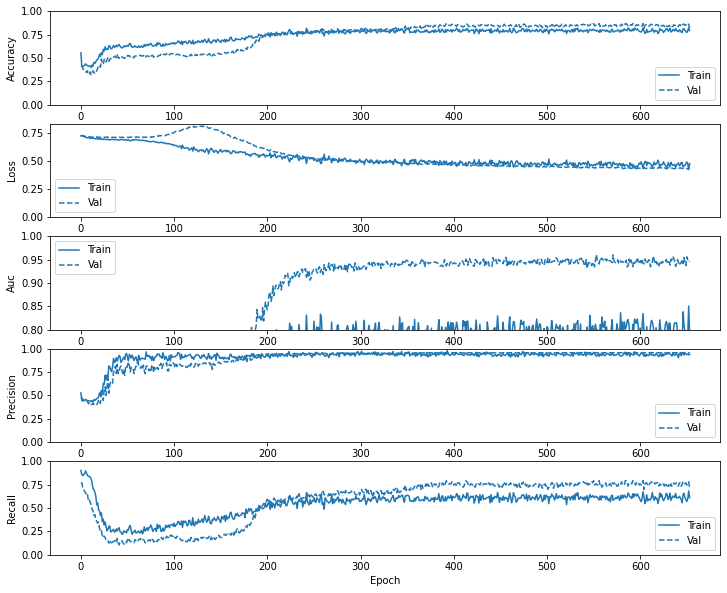

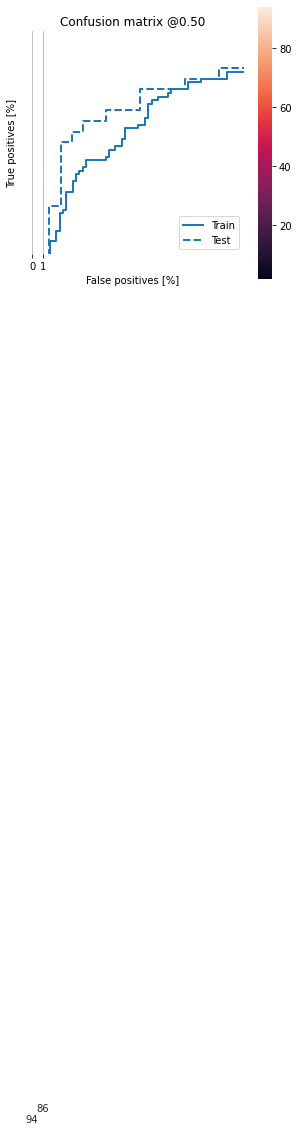

In [22]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [23]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [24]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_5 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 2s 56ms/step - loss: 0.7219 - tp: 139.5000 - fp: 15.0714 - tn: 271.4286 - fn: 142.8571 - accuracy: 0.7370 - precision: 0.9060 - recall: 0.5237 - auc: 0.7413 - val_loss: 0.6798 - val_tp: 34.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 52.0000 - val_accuracy: 0.6038 - val_precision: 0.7556 - val_recall: 0.3953 - val_auc: 0.5277

13/13 [==============================] - 0s 6ms/step - loss: 0.6285 - tp: 62.1429 - fp: 11.3571 - tn: 178.4286 - fn: 117.9286 - accuracy: 0.6543 - precision: 0.8502 - recall: 0.3342 - auc: 0.6193 - val_loss: 0.5557 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 30.0000 - val_accuracy: 0.7610 - val_precision: 0.8750 - val_recall: 0.6512 - val_auc: 0.8202
Epoch 21/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.6123 - tp: 70.5000 - fp: 9.0000 - tn: 179.2143 - fn: 111.1429 - accuracy: 0.6852 - precision: 0.9026 - recall: 0.4016 - auc: 0.6502 - val_loss: 0.5526 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 30.0000 - val_accuracy: 0.7673 - val_precision: 0.8889 - val_recall: 0.6512 - val_auc: 0.8214
Epoch 22/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.6104 - tp: 71.4286 - fp: 11.5000 - tn: 176.0714 - fn: 110.8571 - accuracy: 0.6622 - precision: 0.8699 - recall: 0.3830 - auc: 0.6580 - val_loss: 0.5500 - val_tp: 56

13/13 [==============================] - 0s 7ms/step - loss: 0.6091 - tp: 59.0714 - fp: 10.9286 - tn: 179.7857 - fn: 120.0714 - accuracy: 0.6333 - precision: 0.8598 - recall: 0.3159 - auc: 0.6379 - val_loss: 0.5134 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.7925 - val_precision: 0.9077 - val_recall: 0.6860 - val_auc: 0.8596
Epoch 42/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5634 - tp: 71.0000 - fp: 8.7143 - tn: 188.8571 - fn: 101.2857 - accuracy: 0.7145 - precision: 0.8999 - recall: 0.4204 - auc: 0.7201 - val_loss: 0.5120 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8587
Epoch 43/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5910 - tp: 65.7857 - fp: 10.2857 - tn: 181.5000 - fn: 112.2857 - accuracy: 0.6634 - precision: 0.8666 - recall: 0.3504 - auc: 0.6852 - val_loss: 0.5110 - val_tp: 59

13/13 [==============================] - 0s 7ms/step - loss: 0.5836 - tp: 68.2857 - fp: 8.4286 - tn: 180.7143 - fn: 112.4286 - accuracy: 0.6723 - precision: 0.8888 - recall: 0.3720 - auc: 0.6929 - val_loss: 0.4968 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8676
Epoch 63/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.6028 - tp: 63.4286 - fp: 13.6429 - tn: 180.8571 - fn: 111.9286 - accuracy: 0.6584 - precision: 0.7919 - recall: 0.3628 - auc: 0.6757 - val_loss: 0.4963 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8690
Epoch 64/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5579 - tp: 74.5000 - fp: 11.3571 - tn: 180.2857 - fn: 103.7143 - accuracy: 0.6857 - precision: 0.8761 - recall: 0.4121 - auc: 0.7283 - val_loss: 0.4953 - val_tp: 57

13/13 [==============================] - 0s 7ms/step - loss: 0.5726 - tp: 72.7857 - fp: 12.3571 - tn: 174.9286 - fn: 109.7857 - accuracy: 0.6662 - precision: 0.8706 - recall: 0.3806 - auc: 0.7171 - val_loss: 0.4787 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8773
Epoch 84/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5872 - tp: 65.1429 - fp: 10.6429 - tn: 182.3571 - fn: 111.7143 - accuracy: 0.6591 - precision: 0.8619 - recall: 0.3479 - auc: 0.6884 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8810
Epoch 85/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5342 - tp: 78.1429 - fp: 7.3571 - tn: 186.2857 - fn: 98.0714 - accuracy: 0.7250 - precision: 0.9222 - recall: 0.4546 - auc: 0.7475 - val_loss: 0.4773 - val_tp: 57.

13/13 [==============================] - 0s 6ms/step - loss: 0.5363 - tp: 67.5000 - fp: 5.4286 - tn: 189.4286 - fn: 107.5000 - accuracy: 0.6901 - precision: 0.9313 - recall: 0.3795 - auc: 0.7499 - val_loss: 0.4481 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.9122
Epoch 105/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5187 - tp: 66.1429 - fp: 6.1429 - tn: 189.4286 - fn: 108.1429 - accuracy: 0.6998 - precision: 0.9219 - recall: 0.3771 - auc: 0.7719 - val_loss: 0.4459 - val_tp: 61.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 25.0000 - val_accuracy: 0.8113 - val_precision: 0.9242 - val_recall: 0.7093 - val_auc: 0.9103
Epoch 106/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5369 - tp: 74.8571 - fp: 11.6429 - tn: 176.2143 - fn: 107.1429 - accuracy: 0.6758 - precision: 0.8678 - recall: 0.4182 - auc: 0.7580 - val_loss: 0.4449 - val_tp: 6

13/13 [==============================] - 0s 7ms/step - loss: 0.5248 - tp: 70.2143 - fp: 8.9286 - tn: 185.2143 - fn: 105.5000 - accuracy: 0.6852 - precision: 0.8623 - recall: 0.3935 - auc: 0.7712 - val_loss: 0.4194 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9307
Epoch 126/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5285 - tp: 66.3571 - fp: 10.2143 - tn: 183.8571 - fn: 109.4286 - accuracy: 0.6723 - precision: 0.8554 - recall: 0.3661 - auc: 0.7713 - val_loss: 0.4180 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9314
Epoch 127/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5239 - tp: 70.8571 - fp: 6.1429 - tn: 180.5714 - fn: 112.2857 - accuracy: 0.6821 - precision: 0.9373 - recall: 0.3987 - auc: 0.7832 - val_loss: 0.4160 - val_tp: 6

13/13 [==============================] - 0s 10ms/step - loss: 0.4946 - tp: 69.8571 - fp: 7.0000 - tn: 180.8571 - fn: 112.1429 - accuracy: 0.6851 - precision: 0.9167 - recall: 0.3964 - auc: 0.7929 - val_loss: 0.3983 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9422
Epoch 147/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4720 - tp: 85.6429 - fp: 7.2857 - tn: 179.0000 - fn: 97.9286 - accuracy: 0.7163 - precision: 0.9283 - recall: 0.4717 - auc: 0.8224 - val_loss: 0.3976 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9423
Epoch 148/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5006 - tp: 71.0714 - fp: 10.1429 - tn: 181.5000 - fn: 107.1429 - accuracy: 0.6886 - precision: 0.8726 - recall: 0.4152 - auc: 0.8039 - val_loss: 0.3971 - val_tp: 6

13/13 [==============================] - 0s 6ms/step - loss: 0.4994 - tp: 69.9286 - fp: 10.2143 - tn: 181.9286 - fn: 107.7857 - accuracy: 0.6837 - precision: 0.8612 - recall: 0.3964 - auc: 0.7840 - val_loss: 0.3848 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9482
Epoch 168/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4655 - tp: 87.7857 - fp: 5.8571 - tn: 178.3571 - fn: 97.8571 - accuracy: 0.7119 - precision: 0.9442 - recall: 0.4776 - auc: 0.8301 - val_loss: 0.3837 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9483
Epoch 169/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4843 - tp: 73.9286 - fp: 6.2143 - tn: 184.7857 - fn: 104.9286 - accuracy: 0.6951 - precision: 0.9247 - recall: 0.4104 - auc: 0.8039 - val_loss: 0.3836 - val_tp: 65

13/13 [==============================] - 0s 7ms/step - loss: 0.4686 - tp: 72.4286 - fp: 4.7143 - tn: 187.5000 - fn: 105.2143 - accuracy: 0.7052 - precision: 0.9441 - recall: 0.4022 - auc: 0.8186 - val_loss: 0.3790 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9526
Epoch 189/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4916 - tp: 75.8571 - fp: 10.5000 - tn: 180.1429 - fn: 103.3571 - accuracy: 0.6953 - precision: 0.8758 - recall: 0.4334 - auc: 0.7996 - val_loss: 0.3786 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9532
Epoch 190/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4781 - tp: 63.5000 - fp: 7.5000 - tn: 189.6429 - fn: 109.2143 - accuracy: 0.6857 - precision: 0.8891 - recall: 0.3690 - auc: 0.8131 - val_loss: 0.3780 - val_tp: 6

13/13 [==============================] - 0s 6ms/step - loss: 0.4750 - tp: 74.6429 - fp: 6.5714 - tn: 180.7857 - fn: 107.8571 - accuracy: 0.6928 - precision: 0.9176 - recall: 0.4169 - auc: 0.8115 - val_loss: 0.3676 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9548
Epoch 210/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4876 - tp: 70.2857 - fp: 7.0000 - tn: 185.7143 - fn: 106.8571 - accuracy: 0.6914 - precision: 0.9089 - recall: 0.3837 - auc: 0.7934 - val_loss: 0.3673 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9541
Epoch 211/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5002 - tp: 58.2143 - fp: 4.2143 - tn: 186.9286 - fn: 120.5000 - accuracy: 0.6588 - precision: 0.9385 - recall: 0.3151 - auc: 0.7805 - val_loss: 0.3664 - val_tp: 68

13/13 [==============================] - 0s 8ms/step - loss: 0.4552 - tp: 82.9286 - fp: 8.0000 - tn: 181.7857 - fn: 97.1429 - accuracy: 0.7134 - precision: 0.9028 - recall: 0.4610 - auc: 0.8272 - val_loss: 0.3600 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 231/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4497 - tp: 81.0000 - fp: 6.5000 - tn: 176.8571 - fn: 105.5000 - accuracy: 0.6943 - precision: 0.9288 - recall: 0.4522 - auc: 0.8279 - val_loss: 0.3591 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 232/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4763 - tp: 70.2143 - fp: 7.2143 - tn: 190.0000 - fn: 102.4286 - accuracy: 0.7101 - precision: 0.9198 - recall: 0.4144 - auc: 0.8093 - val_loss: 0.3577 - val_tp: 69.

13/13 [==============================] - 0s 7ms/step - loss: 0.4554 - tp: 82.6429 - fp: 5.4286 - tn: 183.5714 - fn: 98.2143 - accuracy: 0.7192 - precision: 0.9416 - recall: 0.4634 - auc: 0.8269 - val_loss: 0.3507 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9530
Epoch 252/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4639 - tp: 73.4286 - fp: 8.0714 - tn: 188.2857 - fn: 100.0714 - accuracy: 0.7144 - precision: 0.8893 - recall: 0.4311 - auc: 0.8182 - val_loss: 0.3504 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9529
Epoch 253/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4620 - tp: 72.5714 - fp: 5.9286 - tn: 187.8571 - fn: 103.5000 - accuracy: 0.7111 - precision: 0.9255 - recall: 0.4182 - auc: 0.8165 - val_loss: 0.3504 - val_tp: 73.

13/13 [==============================] - 0s 7ms/step - loss: 0.4771 - tp: 82.6429 - fp: 7.4286 - tn: 182.1429 - fn: 97.6429 - accuracy: 0.7091 - precision: 0.9176 - recall: 0.4443 - auc: 0.8156 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9529
Epoch 273/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4725 - tp: 66.2857 - fp: 6.8571 - tn: 189.6429 - fn: 107.0714 - accuracy: 0.6931 - precision: 0.9324 - recall: 0.3728 - auc: 0.8091 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9534
Epoch 274/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4407 - tp: 82.9286 - fp: 6.0000 - tn: 192.7143 - fn: 88.2143 - accuracy: 0.7600 - precision: 0.9203 - recall: 0.4972 - auc: 0.8366 - val_loss: 0.3439 - val_tp: 74.0

13/13 [==============================] - 0s 7ms/step - loss: 0.4734 - tp: 72.0714 - fp: 7.3571 - tn: 185.3571 - fn: 105.0714 - accuracy: 0.6989 - precision: 0.8953 - recall: 0.4087 - auc: 0.7985 - val_loss: 0.3422 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9535
Epoch 294/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4813 - tp: 66.0714 - fp: 6.6429 - tn: 186.9286 - fn: 110.2143 - accuracy: 0.6750 - precision: 0.9248 - recall: 0.3662 - auc: 0.7944 - val_loss: 0.3424 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9536
Epoch 295/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4533 - tp: 82.2857 - fp: 6.5714 - tn: 182.5714 - fn: 98.4286 - accuracy: 0.7241 - precision: 0.9298 - recall: 0.4674 - auc: 0.8258 - val_loss: 0.3421 - val_tp: 74.

13/13 [==============================] - 0s 7ms/step - loss: 0.4348 - tp: 77.8571 - fp: 5.2857 - tn: 191.4286 - fn: 95.2857 - accuracy: 0.7360 - precision: 0.9454 - recall: 0.4551 - auc: 0.8469 - val_loss: 0.3363 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9560
Epoch 315/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4428 - tp: 76.8571 - fp: 5.9286 - tn: 187.5000 - fn: 99.5714 - accuracy: 0.7265 - precision: 0.9419 - recall: 0.4517 - auc: 0.8384 - val_loss: 0.3358 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9564
Epoch 316/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4632 - tp: 81.9286 - fp: 5.2857 - tn: 185.1429 - fn: 97.5000 - accuracy: 0.7108 - precision: 0.9416 - recall: 0.4441 - auc: 0.8231 - val_loss: 0.3357 - val_tp: 74.00

13/13 [==============================] - 0s 6ms/step - loss: 0.4607 - tp: 85.1429 - fp: 9.7143 - tn: 177.6429 - fn: 97.3571 - accuracy: 0.7120 - precision: 0.8818 - recall: 0.4705 - auc: 0.8114 - val_loss: 0.3296 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9556
Epoch 336/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4805 - tp: 79.0714 - fp: 6.2143 - tn: 182.6429 - fn: 101.9286 - accuracy: 0.7102 - precision: 0.9338 - recall: 0.4484 - auc: 0.8050 - val_loss: 0.3302 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9552
Epoch 337/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4600 - tp: 76.8571 - fp: 6.1429 - tn: 193.7857 - fn: 93.0714 - accuracy: 0.7271 - precision: 0.9071 - recall: 0.4415 - auc: 0.8155 - val_loss: 0.3296 - val_tp: 74.0

13/13 [==============================] - 0s 7ms/step - loss: 0.4648 - tp: 66.4286 - fp: 7.6429 - tn: 192.4286 - fn: 103.3571 - accuracy: 0.7106 - precision: 0.8870 - recall: 0.3799 - auc: 0.8083 - val_loss: 0.3313 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9553
Epoch 357/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4500 - tp: 74.7857 - fp: 4.6429 - tn: 191.2143 - fn: 99.2143 - accuracy: 0.7193 - precision: 0.9545 - recall: 0.4220 - auc: 0.8296 - val_loss: 0.3294 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9545
Epoch 358/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4764 - tp: 80.7143 - fp: 3.0714 - tn: 188.0000 - fn: 98.0714 - accuracy: 0.7198 - precision: 0.9528 - recall: 0.4403 - auc: 0.8034 - val_loss: 0.3284 - val_tp: 75.0

13/13 [==============================] - 0s 6ms/step - loss: 0.4418 - tp: 78.9286 - fp: 5.7857 - tn: 194.1429 - fn: 91.0000 - accuracy: 0.7465 - precision: 0.9343 - recall: 0.4646 - auc: 0.8287 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 378/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4340 - tp: 83.1429 - fp: 8.7143 - tn: 185.9286 - fn: 92.0714 - accuracy: 0.7351 - precision: 0.9077 - recall: 0.4867 - auc: 0.8430 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9542
Epoch 379/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4420 - tp: 77.7857 - fp: 4.7143 - tn: 187.4286 - fn: 99.9286 - accuracy: 0.7183 - precision: 0.9529 - recall: 0.4412 - auc: 0.8356 - val_loss: 0.3257 - val_tp: 75.00

13/13 [==============================] - 0s 7ms/step - loss: 0.4954 - tp: 74.0000 - fp: 6.5714 - tn: 182.1429 - fn: 107.1429 - accuracy: 0.6870 - precision: 0.9211 - recall: 0.3954 - auc: 0.7932 - val_loss: 0.3263 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9540
Epoch 399/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4880 - tp: 83.1429 - fp: 5.3571 - tn: 182.6429 - fn: 98.7143 - accuracy: 0.7101 - precision: 0.9335 - recall: 0.4624 - auc: 0.7927 - val_loss: 0.3267 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 400/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4478 - tp: 82.6429 - fp: 5.0714 - tn: 185.1429 - fn: 97.0000 - accuracy: 0.7124 - precision: 0.9433 - recall: 0.4515 - auc: 0.8407 - val_loss: 0.3253 - val_tp: 75.0

13/13 [==============================] - 0s 7ms/step - loss: 0.4512 - tp: 79.8571 - fp: 5.2857 - tn: 187.7143 - fn: 97.0000 - accuracy: 0.7160 - precision: 0.9286 - recall: 0.4512 - auc: 0.8264 - val_loss: 0.3215 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
loss :  0.28389766812324524
tp :  95.0
fp :  4.0
tn :  92.0
fn :  8.0
accuracy :  0.9396985173225403
precision :  0.9595959782600403
recall :  0.9223300814628601
auc :  0.978762149810791

Legitimate Domain Name Detected (True Negatives):  92
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  4
Botnet DGA Missed (False Negatives):  8
Botnet DGA Detected (True Positives):  95
Total Botnet DGAs:  103
CPU times: user 1min 1s, sys: 4.1 s, total: 1min 5s
Wall time: 51.7 s


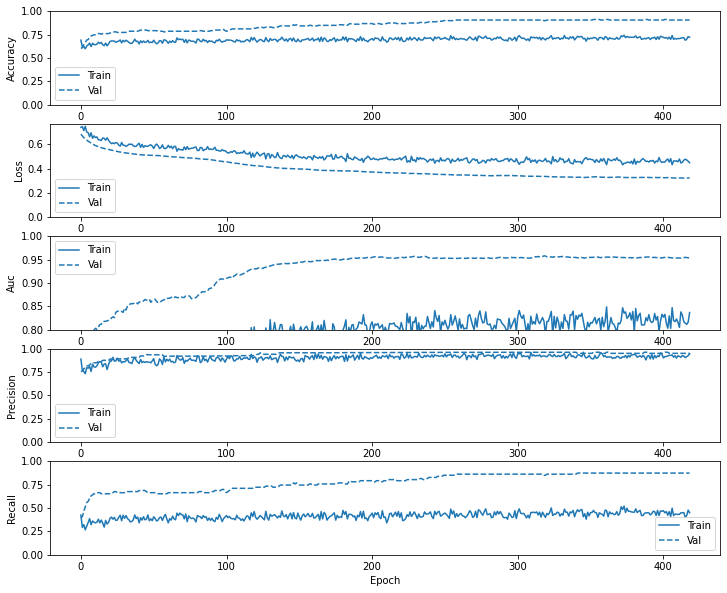

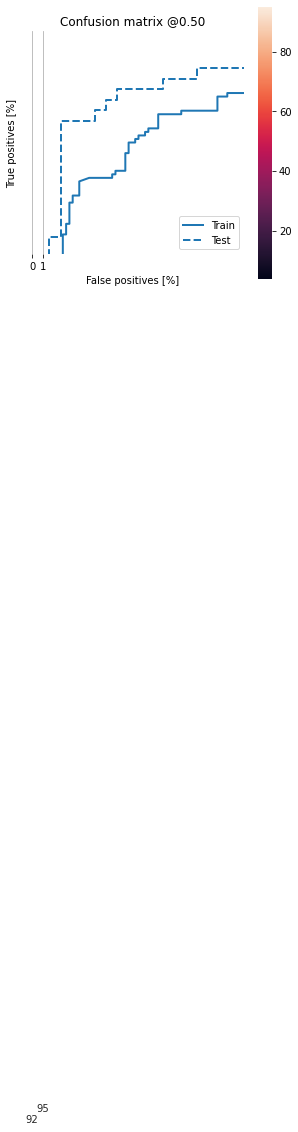

In [25]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [26]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmq_5_yorktown - qiskit.aer - seed 123")
f.flush()